In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, Subset
import copy
import random
from collections import Counter
import matplotlib.pyplot as plt
import time

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
NUM_CLASSES = 10

# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.01
LOCAL_EPOCHS = 5
NUM_OF_CLIENTS = 10
COMM_ROUND = 50
ALPHA = 0.5
FRAC = 0.1
RHO = 0.05  # SAM perturbation radius (from paper)

Using device: cuda


In [2]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.conv7 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((2, 2))
        self.fc1 = nn.Linear(512 * 2 * 2, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.bn_fc2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        f1 = F.relu(self.bn_fc1(self.fc1(x)))
        f1 = self.dropout1(f1)
        f2 = F.relu(self.bn_fc2(self.fc2(f1)))
        f2 = self.dropout2(f2)
        logits = self.fc3(f2)
        return f2, logits  # features, logits


def load_and_partition_data(num_clients=NUM_OF_CLIENTS, alpha=ALPHA, batch_size=BATCH_SIZE, frac=FRAC, rand_seed=42):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    torch.manual_seed(rand_seed)
    np.random.seed(rand_seed)

    full_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    y_train = np.array(full_dataset.targets)
    y_test = np.array(test_dataset.targets)

    net_dataidx_map = {}
    net_dataidx_map_test = {}

    min_size = 0
    while min_size < 10:
        idx_batch = [[] for _ in range(num_clients)]
        idx_batch_test = [[] for _ in range(num_clients)]
        for k in range(10):
            idx_k = np.where(y_train == k)[0]
            idx_k_test = np.where(y_test == k)[0]
            np.random.shuffle(idx_k)
            np.random.shuffle(idx_k_test)
            proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
            proportions_train = np.array([p * (len(idx_j) < len(full_dataset)/num_clients) for p, idx_j in zip(proportions, idx_batch)])
            proportions_test = np.array([p * (len(idx_j) < len(test_dataset)/num_clients) for p, idx_j in zip(proportions, idx_batch_test)])
            proportions_train /= proportions_train.sum()
            proportions_test /= proportions_test.sum()
            split_train = (np.cumsum(proportions_train) * len(idx_k)).astype(int)[:-1]
            split_test = (np.cumsum(proportions_test) * len(idx_k_test)).astype(int)[:-1]
            idx_batch = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, np.split(idx_k, split_train))]
            idx_batch_test = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch_test, np.split(idx_k_test, split_test))]
        min_size = min(len(l) for l in idx_batch)

    for j in range(num_clients):
        np.random.shuffle(idx_batch[j])
        np.random.shuffle(idx_batch_test[j])
        net_dataidx_map[j] = idx_batch[j]
        net_dataidx_map_test[j] = idx_batch_test[j]

    client_train_loaders = []
    client_val_loaders = []
    client_class_dist = []

    for i in range(num_clients):
        np.random.seed(rand_seed + i)
        train_idx = np.random.choice(net_dataidx_map[i], int(frac * len(net_dataidx_map[i])), replace=False)
        val_idx = np.random.choice(net_dataidx_map_test[i], int(min(2*frac,1.0)*len(net_dataidx_map_test[i])), replace=False)

        client_labels = [y_train[k] for k in train_idx]
        dist = {c: client_labels.count(c)/len(client_labels) if client_labels else 0 for c in range(10)}
        client_class_dist.append(dist)

        train_loader = DataLoader(Subset(full_dataset, train_idx), batch_size=batch_size,
                                  shuffle=True, generator=torch.Generator().manual_seed(rand_seed+i), drop_last=True)
        val_loader = DataLoader(Subset(test_dataset, val_idx), batch_size=batch_size,
                                shuffle=True, generator=torch.Generator().manual_seed(rand_seed+i+num_clients), drop_last=True)
        client_train_loaders.append(train_loader)
        client_val_loaders.append(val_loader)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                             generator=torch.Generator().manual_seed(rand_seed + 2*num_clients + 1))

    print("Data partitioning complete.")
    for i, d in enumerate(client_class_dist):
        print(f"Client {i} class dist: {[f'{c}:{d.get(c,0):.2f}' for c in range(10)]}")

    # return client_train_loaders, client_val_loaders, test_loader
    return client_train_loaders, client_val_loaders, test_loader, client_class_dist

# train_loaders, val_loaders, test_loader = load_and_partition_data()

train_loaders, val_loaders, test_loader, client_class_dist = load_and_partition_data()

# ========================================
# 3. TEMPNET
# ========================================
class TempNet(nn.Module):
    def __init__(self, feature_dim=512, hidden_dim=128, tau_min=0.05, tau_max=2.0):
        super().__init__()
        self.fc1 = nn.Linear(feature_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.tau_min = tau_min
        self.tau_max = tau_max

    def forward(self, x):
        h = F.relu(self.fc1(x))
        raw = self.fc2(h)
        tau = torch.sigmoid(raw)
        tau = tau * (self.tau_max - self.tau_min) + self.tau_min
        return tau.mean()

100%|██████████| 170M/170M [00:01<00:00, 106MB/s]  


Data partitioning complete.
Client 0 class dist: ['0:0.03', '1:0.01', '2:0.26', '3:0.23', '4:0.09', '5:0.00', '6:0.38', '7:0.00', '8:0.00', '9:0.00']
Client 1 class dist: ['0:0.05', '1:0.00', '2:0.23', '3:0.06', '4:0.02', '5:0.00', '6:0.00', '7:0.06', '8:0.18', '9:0.40']
Client 2 class dist: ['0:0.04', '1:0.02', '2:0.00', '3:0.20', '4:0.00', '5:0.70', '6:0.04', '7:0.00', '8:0.00', '9:0.00']
Client 3 class dist: ['0:0.40', '1:0.60', '2:0.00', '3:0.00', '4:0.00', '5:0.00', '6:0.00', '7:0.00', '8:0.00', '9:0.00']
Client 4 class dist: ['0:0.16', '1:0.09', '2:0.00', '3:0.06', '4:0.21', '5:0.06', '6:0.10', '7:0.31', '8:0.00', '9:0.00']
Client 5 class dist: ['0:0.11', '1:0.07', '2:0.35', '3:0.12', '4:0.03', '5:0.17', '6:0.03', '7:0.00', '8:0.10', '9:0.02']
Client 6 class dist: ['0:0.01', '1:0.06', '2:0.11', '3:0.01', '4:0.00', '5:0.06', '6:0.01', '7:0.53', '8:0.00', '9:0.22']
Client 7 class dist: ['0:0.12', '1:0.02', '2:0.03', '3:0.18', '4:0.06', '5:0.05', '6:0.11', '7:0.13', '8:0.01', '9:0.2

In [3]:
class BaseClient:
    """Base class for federated learning clients"""
    
    def __init__(self, client_id, model, train_loader, val_loader, device, 
                 learning_rate=0.01, local_epochs=5, momentum=0.9):
        self.client_id = client_id
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.learning_rate = learning_rate
        self.local_epochs = local_epochs
        self.momentum = momentum
        self.loss_fn = nn.CrossEntropyLoss()
        self.train_samples = 0
    
    def train(self):
        raise NotImplementedError
    
    def set_parameters(self, model_state_dict):
        """Load model parameters from server"""
        self.model.load_state_dict(model_state_dict)
    
    def get_parameters(self):
        """Get model parameters"""
        return self.model.state_dict()
    
    def get_train_samples(self):
        """Get number of training samples"""
        try:
            return len(self.train_loader.dataset)
        except:
            return len(self.train_loader) * BATCH_SIZE


class BaseServer:
    """Base class for federated learning server"""
    
    def __init__(self, global_model, test_loader, num_clients, learning_rate=0.01, 
                 lr_decay=0.998, device='cuda'):
        self.global_model = copy.deepcopy(global_model)
        self.test_loader = test_loader
        self.num_clients = num_clients
        self.learning_rate = learning_rate
        self.lr_decay = lr_decay
        self.device = device
        self.clients = []
        self.loss_fn = nn.CrossEntropyLoss()
    
    def send_models(self, clients):
        """Send global model to clients"""
        model_state = self.global_model.state_dict()
        for client in clients:
            client.set_parameters(model_state)
    
    def receive_models(self, clients):
        """Receive trained models from clients and aggregate"""
        self.client_models = [client.get_parameters() for client in clients]
        self.client_samples = [client.get_train_samples() for client in clients]
    
    def aggregate_parameters(self):
        """Aggregate client models using weighted averaging
        
        IMPORTANT: This method handles mixed dtypes in model state dict.
        Batch normalization layers have both float parameters AND integer buffers 
        (like num_batches_tracked). We must convert to float for weighted averaging,
        then convert back to original dtype to avoid RuntimeError.
        """
        total_samples = sum(self.client_samples)
        avg_state = {}
        
        # Get first model as reference
        for key in self.client_models[0].keys():
            # Get original dtype (may be float32, float64, or int64)
            first_tensor = self.client_models[0][key]
            original_dtype = first_tensor.dtype
            
            # Initialize accumulator with zeros, using float32 for safe averaging
            avg_state[key] = torch.zeros_like(first_tensor, dtype=torch.float32)
            
            # Weighted average: convert each tensor to float before summing
            for model_state, num_samples in zip(self.client_models, self.client_samples):
                weight = num_samples / total_samples
                # .float() converts int64 buffers to float32, allows weighted addition
                avg_state[key] += weight * model_state[key].float()
            
            # Convert result back to original dtype
            # Float params stay float, int buffers become int again
            avg_state[key] = avg_state[key].to(original_dtype)
        
        self.global_model.load_state_dict(avg_state)
    
    def evaluate(self):
        """Evaluate global model on test data"""
        self.global_model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for X, y in self.test_loader:
                X, y = X.to(self.device), y.to(self.device)
                output = self.model_forward(X)
                if isinstance(output, tuple):
                    _, logits = output
                else:
                    logits = output
                _, predicted = torch.max(logits, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
        
        accuracy = correct / total
        return accuracy
    
    def model_forward(self, X):
        """Forward pass through model"""
        return self.global_model(X)


# ========================================
# FEDAVG IMPLEMENTATION
# ========================================

class ClientFedAvg(BaseClient):
    """Standard FedAvg client using SGD"""
    
    def train(self):
        self.model.train()
        optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        
        for epoch in range(self.local_epochs):
            for X, y in self.train_loader:
                X, y = X.to(self.device), y.to(self.device)
                
                optimizer.zero_grad()
                output = self.model(X)
                if isinstance(output, tuple):
                    _, logits = output
                else:
                    logits = output
                loss = self.loss_fn(logits, y)
                loss.backward()
                optimizer.step()


class FedAvgServer(BaseServer):
    """Standard FedAvg server"""
    
    def __init__(self, global_model, test_loader, num_clients, client_loaders, 
                 learning_rate=0.01, lr_decay=0.998, device='cuda', local_epochs=5):
        super().__init__(global_model, test_loader, num_clients, learning_rate, 
                        lr_decay, device)
        self.local_epochs = local_epochs
        
        for i, (train_loader, val_loader) in enumerate(client_loaders):
            client = ClientFedAvg(i, copy.deepcopy(global_model), train_loader, 
                                 val_loader, device, learning_rate=learning_rate, 
                                 local_epochs=local_epochs)
            client.train_samples = client.get_train_samples()
            self.clients.append(client)
    
    def train_round(self):
        """Execute one communication round"""
        self.send_models(self.clients)
        
        for client in self.clients:
            client.train()
        
        self.receive_models(self.clients)
        self.aggregate_parameters()
        
        acc = self.evaluate()
        self.learning_rate *= self.lr_decay
        
        return acc


# ========================================
# FEDAVG + TEMPNET IMPLEMENTATION
# ========================================

class ClientFedAvgTemp(BaseClient):
    """FedAvg + Temperature: Standard SGD with learned temperature scaling"""
    
    def __init__(self, client_id, model, train_loader, val_loader, device, 
                 learning_rate=0.01, local_epochs=5, momentum=0.9, train_samples=None):
        super().__init__(client_id, model, train_loader, val_loader, device, 
                        learning_rate, local_epochs, momentum)
        self.train_samples = train_samples or 0
        self.tempnet = TempNet(feature_dim=512, hidden_dim=128).to(device)
        self.temp_optimizer = optim.SGD(self.tempnet.parameters(), 
                                       lr=learning_rate)
    
    def train(self):
        self.model.train()
        self.tempnet.train()
        optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        
        for epoch in range(self.local_epochs):
            for X, y in self.train_loader:
                X, y = X.to(self.device), y.to(self.device)
                
                optimizer.zero_grad()
                self.temp_optimizer.zero_grad()
                output = self.model(X)
                if isinstance(output, tuple):
                    features, logits = output
                else:
                    features = None
                    logits = output
                
                tau = self.tempnet(features.detach()) if features is not None else torch.tensor(1.0, device=self.device)
                scaled_logits = logits / tau
                loss = self.loss_fn(scaled_logits, y)
                loss.backward()
                
                optimizer.step()
                self.temp_optimizer.step()
    
    def get_temperature(self):
        """Get current temperature value"""
        self.model.eval()
        self.tempnet.eval()
        try:
            with torch.no_grad():
                X, _ = next(iter(self.train_loader))
                X = X.to(self.device)
                output = self.model(X)
                if isinstance(output, tuple):
                    features, _ = output
                    tau = self.tempnet(features)
                    return tau.item()
                else:
                    return 1.0
        except:
            return 1.0


class FedAvgTempServer(BaseServer):
    """FedAvg + Temperature Server"""
    
    def __init__(self, global_model, test_loader, num_clients, client_loaders, 
                 learning_rate=0.01, lr_decay=0.998, device='cuda', local_epochs=5):
        super().__init__(global_model, test_loader, num_clients, learning_rate, 
                        lr_decay, device)
        self.local_epochs = local_epochs
        self.tau_history = []
        
        for i, (train_loader, val_loader) in enumerate(client_loaders):
            client = ClientFedAvgTemp(i, copy.deepcopy(global_model), train_loader, 
                                     val_loader, device, learning_rate=learning_rate, 
                                     local_epochs=local_epochs)
            client.train_samples = client.get_train_samples()
            self.clients.append(client)
    
    def train_round(self):
        self.send_models(self.clients)
        
        local_taus = []
        for client in self.clients:
            client.train()
            tau = client.get_temperature()
            local_taus.append(tau)
        
        self.receive_models(self.clients)
        self.aggregate_parameters()
        
        acc = self.evaluate()
        avg_tau = sum(local_taus) / len(local_taus) if local_taus else 1.0
        self.tau_history.append(avg_tau)
        
        self.learning_rate *= self.lr_decay
        
        return acc, avg_tau

# ========================================
# SAM OPTIMIZER (Sharpness Aware Minimization)
# ========================================

class SAMOptimizer(optim.Optimizer):
    """SAM optimizer - Sharpness Aware Minimization"""
    
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho: {rho}"
        defaults = dict(rho=rho, adaptive=adaptive)
        super().__init__(params, defaults)
        
        self.base_optimizer = base_optimizer
        self.param_groups = self.base_optimizer.param_groups
        for group in self.param_groups:
            group["rho"] = rho
            group["adaptive"] = adaptive
    
    @torch.no_grad()
    def first_step(self):
        """Perturbation step: climb to local maximum"""
        grad_norm = self._grad_norm()
        
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-7)
            for p in group["params"]:
                if p.grad is None:
                    continue
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # Move to perturbed point θ + ε
                self.state[p]["e_w"] = e_w
    
    @torch.no_grad()
    def second_step(self):
        """Restore to original point (do this BEFORE applying gradients)"""
        for group in self.param_groups:
            for p in group["params"]:
                if "e_w" in self.state[p]:
                    p.sub_(self.state[p]["e_w"])  # Return to original θ
                    self.state[p]["e_w"] = 0
    
    def _grad_norm(self):
        """Compute gradient norm across all parameters"""
        norm = torch.norm(torch.stack([
            ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2)
            for group in self.param_groups for p in group["params"]
            if p.grad is not None
        ]), p=2)
        return norm


# ========================================
# FEDSAM IMPLEMENTATION
# ========================================

class ClientFedSAM(BaseClient):
    """FedSAM client using SAM optimizer"""
    
    def __init__(self, client_id, model, train_loader, val_loader, device, 
                 learning_rate=0.01, local_epochs=5, momentum=0.9, rho=0.05, 
                 train_samples=None):
        super().__init__(client_id, model, train_loader, val_loader, device, 
                        learning_rate, local_epochs, momentum)
        self.rho = rho
        self.train_samples = train_samples or 0
    
    def train(self):
        self.model.train()
        base_optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        sam_optimizer = SAMOptimizer(self.model.parameters(), base_optimizer, rho=self.rho)
        
        for epoch in range(self.local_epochs):
            for X, y in self.train_loader:
                X, y = X.to(self.device), y.to(self.device)
                
                # First forward-backward: compute gradient at θ
                base_optimizer.zero_grad()
                output = self.model(X)
                if isinstance(output, tuple):
                    _, logits = output
                else:
                    logits = output
                loss = self.loss_fn(logits, y)
                loss.backward()
                
                # SAM first step: ascent to θ + ε
                sam_optimizer.first_step()
                
                # Second forward-backward: compute gradient at perturbed point θ + ε
                base_optimizer.zero_grad()
                output_pert = self.model(X)
                if isinstance(output_pert, tuple):
                    _, logits_pert = output_pert
                else:
                    logits_pert = output_pert
                loss_pert = self.loss_fn(logits_pert, y)
                loss_pert.backward()
                
                # SAM second step: restore to original θ (BEFORE gradient descent)
                sam_optimizer.second_step()
                
                # Apply gradient from perturbed point to original θ
                base_optimizer.step()


class FedSAMServer(BaseServer):
    """FedSAM server"""
    
    def __init__(self, global_model, test_loader, num_clients, client_loaders, 
                 learning_rate=0.01, lr_decay=0.998, device='cuda', local_epochs=5, 
                 rho=0.05):
        super().__init__(global_model, test_loader, num_clients, learning_rate, 
                        lr_decay, device)
        self.local_epochs = local_epochs
        self.rho = rho
        
        for i, (train_loader, val_loader) in enumerate(client_loaders):
            client = ClientFedSAM(i, copy.deepcopy(global_model), train_loader, 
                                 val_loader, device, learning_rate=learning_rate, 
                                 local_epochs=local_epochs, rho=rho)
            client.train_samples = client.get_train_samples()
            self.clients.append(client)
    
    def train_round(self):
        self.send_models(self.clients)
        
        for client in self.clients:
            client.train()
        
        self.receive_models(self.clients)
        self.aggregate_parameters()
        
        acc = self.evaluate()
        self.learning_rate *= self.lr_decay
        
        return acc


# ========================================
# FEDSAM + TEMPNET IMPLEMENTATION
# ========================================

class ClientFedSAMTemp(BaseClient):
    """FedSAM + Temperature: SAM with learned temperature scaling"""
    
    def __init__(self, client_id, model, train_loader, val_loader, device, 
                 learning_rate=0.01, local_epochs=5, momentum=0.9, rho=0.05, 
                 train_samples=None):
        super().__init__(client_id, model, train_loader, val_loader, device, 
                        learning_rate, local_epochs, momentum)
        self.rho = rho
        self.train_samples = train_samples or 0
        self.tempnet = TempNet(feature_dim=512, hidden_dim=128).to(device)
        self.temp_optimizer = optim.SGD(self.tempnet.parameters(), 
                                       lr=learning_rate)
    
    def train(self):
        self.model.train()
        self.tempnet.train()
        base_optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        sam_optimizer = SAMOptimizer(self.model.parameters(), base_optimizer, rho=self.rho)
        
        for epoch in range(self.local_epochs):
            for X, y in self.train_loader:
                X, y = X.to(self.device), y.to(self.device)
                
                # First forward-backward: compute gradient at θ with temperature
                base_optimizer.zero_grad()
                self.temp_optimizer.zero_grad()
                output = self.model(X)
                if isinstance(output, tuple):
                    features, logits = output
                else:
                    features = None
                    logits = output
                
                tau = self.tempnet(features.detach()) if features is not None else torch.tensor(1.0, device=self.device)
                scaled_logits = logits / tau
                loss = self.loss_fn(scaled_logits, y)
                loss.backward()
                
                # SAM first step: ascent to θ + ε (model only)
                sam_optimizer.first_step()
                
                # Second forward-backward: at perturbed point θ + ε
                base_optimizer.zero_grad()
                self.temp_optimizer.zero_grad()
                output_pert = self.model(X)
                if isinstance(output_pert, tuple):
                    features_pert, logits_pert = output_pert
                else:
                    features_pert = None
                    logits_pert = output_pert
                
                tau_pert = self.tempnet(features_pert.detach()) if features_pert is not None else torch.tensor(1.0, device=self.device)
                scaled_logits_pert = logits_pert / tau_pert
                loss_pert = self.loss_fn(scaled_logits_pert, y)
                loss_pert.backward()
                
                # SAM second step: restore model to original θ (BEFORE gradient descent)
                sam_optimizer.second_step()
                
                # Apply gradients: model gets gradient from perturbed point, tempnet standard update
                base_optimizer.step()
                self.temp_optimizer.step()
    
    def get_temperature(self):
        """Get current temperature value"""
        self.model.eval()
        self.tempnet.eval()
        try:
            with torch.no_grad():
                X, _ = next(iter(self.train_loader))
                X = X.to(self.device)
                output = self.model(X)
                if isinstance(output, tuple):
                    features, _ = output
                    tau = self.tempnet(features)
                    return tau.item()
                else:
                    return 1.0
        except:
            return 1.0


class FedSAMTempServer(BaseServer):
    """FedSAM + Temperature Server"""
    
    def __init__(self, global_model, test_loader, num_clients, client_loaders, 
                 learning_rate=0.01, lr_decay=0.998, device='cuda', local_epochs=5, 
                 rho=0.05):
        super().__init__(global_model, test_loader, num_clients, learning_rate, 
                        lr_decay, device)
        self.local_epochs = local_epochs
        self.rho = rho
        self.tau_history = []
        
        for i, (train_loader, val_loader) in enumerate(client_loaders):
            client = ClientFedSAMTemp(i, copy.deepcopy(global_model), train_loader, 
                                     val_loader, device, learning_rate=learning_rate, 
                                     local_epochs=local_epochs, rho=rho)
            client.train_samples = client.get_train_samples()
            self.clients.append(client)
    
    def train_round(self):
        self.send_models(self.clients)
        
        local_taus = []
        for client in self.clients:
            client.train()
            tau = client.get_temperature()
            local_taus.append(tau)
        
        self.receive_models(self.clients)
        self.aggregate_parameters()
        
        acc = self.evaluate()
        avg_tau = sum(local_taus) / len(local_taus) if local_taus else 1.0
        self.tau_history.append(avg_tau)
        
        self.learning_rate *= self.lr_decay
        
        return acc, avg_tau



In [5]:
# ========================================
# FEDLESAM IMPLEMENTATION
# ========================================
class LESAMOptimizer(optim.Optimizer):
    
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho: {rho}"
        defaults = dict(rho=rho)
        super().__init__(params, defaults)
        
        self.base_optimizer = base_optimizer
        self.param_groups = self.base_optimizer.param_groups
        for group in self.param_groups:
            group["rho"] = rho
    
    @torch.no_grad()
    def first_step(self, g_update=None):
        """Perturbation step using gradient update"""
        if g_update is None:
            g_update = [p.grad.clone() if p.grad is not None else None 
                       for p in self.param_groups[0]["params"]]
        
        grad_norm = torch.norm(torch.stack([
            g.norm(p=2) for g in g_update if g is not None
        ]), p=2)
        
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-7)
            for idx, p in enumerate(group["params"]):
                if g_update[idx] is None:
                    continue
                e_w = g_update[idx] * scale.to(p)
                p.add_(e_w)
                self.state[p]["e_w"] = e_w
    
    @torch.no_grad()
    def second_step(self):
        """Restore step"""
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None or not self.state[p]:
                    continue
                p.sub_(self.state[p]["e_w"])
                self.state[p]["e_w"] = 0


class ClientFedLESAM(BaseClient):
    """FedLESAM Client - SAM with momentum"""
    
    def __init__(self, client_id, model, train_loader, val_loader, device, 
                 learning_rate=0.01, local_epochs=5, momentum=0.9, rho=0.05, 
                 train_samples=None):
        super().__init__(client_id, model, train_loader, val_loader, device, 
                        learning_rate, local_epochs, momentum)
        self.rho = rho
        self.train_samples = train_samples or 0
        self.grad_momentum = None
    
    def train(self):
        self.model.train()
        base_optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        lesam_optimizer = LESAMOptimizer(self.model.parameters(), base_optimizer, rho=self.rho)
        
        for epoch in range(self.local_epochs):
            for X, y in self.train_loader:
                X, y = X.to(self.device), y.to(self.device)
                
                # First forward-backward: compute gradient
                base_optimizer.zero_grad()
                output = self.model(X)
                if isinstance(output, tuple):
                    _, logits = output
                else:
                    logits = output
                loss = self.loss_fn(logits, y)
                loss.backward()
                
                # Initialize gradient momentum
                if self.grad_momentum is None:
                    self.grad_momentum = [p.grad.clone() if p.grad is not None else None 
                                         for p in self.model.parameters()]
                
                # Apply momentum to gradient
                for i, p in enumerate(self.model.parameters()):
                    if p.grad is not None and self.grad_momentum[i] is not None:
                        p.grad.data = p.grad.data + self.momentum * self.grad_momentum[i]
                        self.grad_momentum[i] = p.grad.clone()
                
                # LESAM first step using momentum-updated gradient
                lesam_optimizer.first_step(self.grad_momentum)
                
                # Second forward-backward: at perturbed point
                base_optimizer.zero_grad()
                output_pert = self.model(X)
                if isinstance(output_pert, tuple):
                    _, logits_pert = output_pert
                else:
                    logits_pert = output_pert
                loss_pert = self.loss_fn(logits_pert, y)
                loss_pert.backward()
                
                # LESAM second step: descent
                lesam_optimizer.second_step()
                
                # SGD step
                base_optimizer.step()


class FedLESAMServer(BaseServer):
    """FedLESAM Server"""
    
    def __init__(self, global_model, test_loader, num_clients, client_loaders, 
                 learning_rate=0.01, lr_decay=0.998, device='cuda', local_epochs=5, 
                 rho=0.05):
        super().__init__(global_model, test_loader, num_clients, learning_rate, 
                        lr_decay, device)
        self.local_epochs = local_epochs
        self.rho = rho
        
        for i, (train_loader, val_loader) in enumerate(client_loaders):
            client = ClientFedLESAM(i, copy.deepcopy(global_model), train_loader, 
                                   val_loader, device, learning_rate=learning_rate, 
                                   local_epochs=local_epochs, rho=rho)
            client.train_samples = client.get_train_samples()
            self.clients.append(client)
    
    def train_round(self):
        self.send_models(self.clients)
        
        for client in self.clients:
            client.train()
        
        self.receive_models(self.clients)
        self.aggregate_parameters()
        
        acc = self.evaluate()
        self.learning_rate *= self.lr_decay
        
        return acc


class ClientFedLESAMTemp(BaseClient):
    """FedLESAM + Temperature Client"""
    
    def __init__(self, client_id, model, train_loader, val_loader, device, 
                 learning_rate=0.01, local_epochs=5, momentum=0.9, rho=0.05, 
                 train_samples=None):
        super().__init__(client_id, model, train_loader, val_loader, device, 
                        learning_rate, local_epochs, momentum)
        self.rho = rho
        self.train_samples = train_samples or 0
        self.tempnet = TempNet(feature_dim=512, hidden_dim=128).to(device)
        self.temp_optimizer = optim.SGD(self.tempnet.parameters(), 
                                       lr=learning_rate)
        self.grad_momentum = None
    
    def train(self):
        self.model.train()
        self.tempnet.train()
        base_optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        lesam_optimizer = LESAMOptimizer(self.model.parameters(), base_optimizer, rho=self.rho)
        
        for epoch in range(self.local_epochs):
            for X, y in self.train_loader:
                X, y = X.to(self.device), y.to(self.device)
                
                # First forward-backward
                base_optimizer.zero_grad()
                self.temp_optimizer.zero_grad()
                output = self.model(X)
                if isinstance(output, tuple):
                    features, logits = output
                else:
                    features = None
                    logits = output
                
                tau = self.tempnet(features.detach()) if features is not None else torch.tensor(1.0, device=self.device)
                scaled_logits = logits / tau
                loss = self.loss_fn(scaled_logits, y)
                loss.backward()
                
                # Initialize gradient momentum
                if self.grad_momentum is None:
                    self.grad_momentum = [p.grad.clone() if p.grad is not None else None 
                                         for p in self.model.parameters()]
                
                # Apply momentum
                for i, p in enumerate(self.model.parameters()):
                    if p.grad is not None and self.grad_momentum[i] is not None:
                        p.grad.data = p.grad.data + self.momentum * self.grad_momentum[i]
                        self.grad_momentum[i] = p.grad.clone()
                
                # LESAM first step
                lesam_optimizer.first_step(self.grad_momentum)
                
                # Second forward-backward at perturbed point
                base_optimizer.zero_grad()
                self.temp_optimizer.zero_grad()
                output_pert = self.model(X)
                if isinstance(output_pert, tuple):
                    features_pert, logits_pert = output_pert
                else:
                    features_pert = None
                    logits_pert = output_pert
                
                tau_pert = self.tempnet(features_pert.detach()) if features_pert is not None else torch.tensor(1.0, device=self.device)
                scaled_logits_pert = logits_pert / tau_pert
                loss_pert = self.loss_fn(scaled_logits_pert, y)
                loss_pert.backward()
                
                # LESAM second step
                lesam_optimizer.second_step()
                
                # SGD step
                base_optimizer.step()
                self.temp_optimizer.step()
    
    def get_temperature(self):
        """Get current temperature value"""
        self.model.eval()
        self.tempnet.eval()
        try:
            with torch.no_grad():
                X, _ = next(iter(self.train_loader))
                X = X.to(self.device)
                output = self.model(X)
                if isinstance(output, tuple):
                    features, _ = output
                    tau = self.tempnet(features)
                    return tau.item()
                else:
                    return 1.0
        except:
            return 1.0


class FedLESAMTempServer(BaseServer):
    """FedLESAM + Temperature Server"""
    
    def __init__(self, global_model, test_loader, num_clients, client_loaders, 
                 learning_rate=0.01, lr_decay=0.998, device='cuda', local_epochs=5, 
                 rho=0.05):
        super().__init__(global_model, test_loader, num_clients, learning_rate, 
                        lr_decay, device)
        self.local_epochs = local_epochs
        self.rho = rho
        self.tau_history = []
        
        for i, (train_loader, val_loader) in enumerate(client_loaders):
            client = ClientFedLESAMTemp(i, copy.deepcopy(global_model), train_loader, 
                                       val_loader, device, learning_rate=learning_rate, 
                                       local_epochs=local_epochs, rho=rho)
            client.train_samples = client.get_train_samples()
            self.clients.append(client)
    
    def train_round(self):
        self.send_models(self.clients)
        
        local_taus = []
        for client in self.clients:
            client.train()
            tau = client.get_temperature()
            local_taus.append(tau)
        
        self.receive_models(self.clients)
        self.aggregate_parameters()
        
        acc = self.evaluate()
        avg_tau = sum(local_taus) / len(local_taus) if local_taus else 1.0
        self.tau_history.append(avg_tau)
        
        self.learning_rate *= self.lr_decay
        
        return acc, avg_tau


# ========================================
# FEDSMOO IMPLEMENTATION
# ========================================

class SMOOOptimizer:
    """Optimizer for FedSMOO - combines SAM-like perturbations with smoothness regularization"""
    
    def __init__(self, params, base_optimizer, rho=0.05):
        self.params = list(params)
        self.base_optimizer = base_optimizer
        self.rho = rho
        self.state = {}
        
    def zero_grad(self):
        self.base_optimizer.zero_grad()
    
    @torch.no_grad()
    def first_step(self):
        """Perturb parameters in gradient direction (SAM first step)"""
        grad_norm = self._grad_norm()
        scale = self.rho / (grad_norm + 1e-7)
        
        perturbations = []
        for p in self.params:
            if p.grad is None:
                continue
            # Compute perturbation
            e_w = p.grad * scale
            # Store perturbation
            self.state[p] = {"e_w": e_w.clone()}
            # Apply perturbation
            p.add_(e_w)
            perturbations.append(e_w.reshape(-1))
        
        return torch.cat(perturbations) if perturbations else torch.zeros(1, device=self.params[0].device)
    
    @torch.no_grad()
    def second_step(self):
        """Remove perturbation (SAM second step)"""
        for p in self.params:
            if p in self.state and "e_w" in self.state[p]:
                # Remove perturbation
                p.sub_(self.state[p]["e_w"])
    
    def _grad_norm(self):
        """Compute gradient norm"""
        shared_device = self.params[0].device
        norm = torch.norm(
            torch.stack([
                p.grad.norm(p=2).to(shared_device) for p in self.params 
                if p.grad is not None
            ]),
            p=2
        )
        return norm


def param_to_vector(model):
    """Convert model parameters to a single vector"""
    vec = []
    for param in model.parameters():
        vec.append(param.data.reshape(-1))
    return torch.cat(vec)


def vector_to_param(vector, model):
    """Assign vector values back to model parameters"""
    index = 0
    for param in model.parameters():
        param_size = param.numel()
        param.data.copy_(vector[index:index + param_size].view(param.shape))
        index += param_size


class ClientFedSMOO(BaseClient):
    """FedSMOO Client - Smoothness Optimized Federated Learning"""
    
    def __init__(self, client_id, model, train_loader, val_loader, device, 
                 learning_rate=0.01, local_epochs=5, momentum=0.9, rho=0.05, 
                 beta=0.1, train_samples=None):
        super().__init__(client_id, model, train_loader, val_loader, device, 
                        learning_rate, local_epochs, momentum)
        self.rho = rho
        self.beta = beta
        self.train_samples = train_samples or 0
        
        # FedSMOO specific variables
        self.dual_variable = None
        self.global_s = None
        self.mu_i = None
        self.local_update = None
        self.local_s_i = None
    
    def initialize_variables(self):
        """Initialize dual variables and momentum terms"""
        with torch.no_grad():
            param_vector = param_to_vector(self.model)
            if self.mu_i is None:
                self.mu_i = torch.zeros_like(param_vector, device=self.device)
            if self.dual_variable is None:
                self.dual_variable = torch.zeros_like(param_vector, device=self.device)
            if self.global_s is None:
                self.global_s = torch.zeros_like(param_vector, device=self.device)
    
    def train(self):
        self.model.train()
        self.initialize_variables()
        
        # Create optimizers
        base_optimizer = optim.SGD(
            self.model.parameters(), 
            lr=self.learning_rate, 
        )
        smoo_optimizer = SMOOOptimizer(
            self.model.parameters(), 
            base_optimizer, 
            rho=self.rho
        )
        
        # Store initial parameters for dual variable update
        with torch.no_grad():
            initial_params = param_to_vector(self.model).clone()
        
        s_i_k_last = None
        
        for epoch in range(self.local_epochs):
            for batch_idx, (X, y) in enumerate(self.train_loader):
                X, y = X.to(self.device), y.to(self.device)
                
                # === Part 1: Standard gradient computation ===
                base_optimizer.zero_grad()
                output = self.model(X)
                if isinstance(output, tuple):
                    _, logits = output
                else:
                    logits = output
                loss = self.loss_fn(logits, y)
                loss.backward()
                
                # Store original gradients before SAM
                original_grads = []
                for p in self.model.parameters():
                    if p.grad is not None:
                        original_grads.append(p.grad.clone())
                
                # === Part 2: Apply smoothness adjustment to gradients ===
                with torch.no_grad():
                    idx = 0
                    for p in self.model.parameters():
                        if p.grad is not None:
                            numel = p.grad.numel()
                            # Subtract smoothness terms from gradient
                            grad_flat = p.grad.reshape(-1)
                            adjustment = self.mu_i[idx:idx+numel] + self.global_s[idx:idx+numel]
                            grad_flat -= adjustment
                            idx += numel
                
                # === Part 3: SAM first step (perturb in gradient direction) ===
                s_i_k = smoo_optimizer.first_step()
                
                # === Part 4: Compute gradient at perturbed point ===
                base_optimizer.zero_grad()
                output_pert = self.model(X)
                if isinstance(output_pert, tuple):
                    _, logits_pert = output_pert
                else:
                    logits_pert = output_pert
                loss_pert = self.loss_fn(logits_pert, y)
                loss_pert.backward()
                
                # === Part 5: SAM second step (return to original point) ===
                smoo_optimizer.second_step()
                
                # === Part 6: Update momentum term ===
                with torch.no_grad():
                    self.mu_i += (s_i_k - self.global_s)
                
                # === Part 7: Apply optimizer step with proximal term ===
                # Add proximal regularization gradient
                with torch.no_grad():
                    current_params = param_to_vector(self.model)
                    # Proximal gradient: beta * (current_params - initial_params - dual_variable)
                    prox_grad = self.beta * (current_params - initial_params + self.dual_variable)
                    
                    idx = 0
                    for p in self.model.parameters():
                        if p.grad is not None:
                            numel = p.grad.numel()
                            # Add proximal gradient term
                            p.grad += prox_grad[idx:idx+numel].view(p.grad.shape)
                            idx += numel
                
                # Apply optimizer step
                base_optimizer.step()
                
                s_i_k_last = s_i_k
        
        # Store local update for server aggregation
        with torch.no_grad():
            final_params = param_to_vector(self.model)
            self.local_update = final_params - initial_params
            if s_i_k_last is not None:
                self.local_s_i = self.mu_i - s_i_k_last
            else:
                self.local_s_i = self.mu_i.clone()


class FedSMOOServer(BaseServer):
    """FedSMOO Server - Coordinates smoothness-optimized federated learning"""
    
    def __init__(self, global_model, test_loader, num_clients, client_loaders, 
                 learning_rate=0.01, lr_decay=0.998, device='cuda', local_epochs=5, 
                 rho=0.05, beta=0.1):
        super().__init__(global_model, test_loader, num_clients, learning_rate, 
                        lr_decay, device)
        self.local_epochs = local_epochs
        self.rho = rho
        self.beta = beta
        
        # Initialize FedSMOO specific variables
        with torch.no_grad():
            init_params = param_to_vector(global_model)
            self.global_s = torch.zeros_like(init_params, device=device)
            self.dual_variable_list = torch.zeros(
                (num_clients, init_params.shape[0]),
                device=device
            )
        
        # Create clients
        for i, (train_loader, val_loader) in enumerate(client_loaders):
            client = ClientFedSMOO(
                i, copy.deepcopy(global_model), train_loader, val_loader, device,
                learning_rate=learning_rate, local_epochs=local_epochs, 
                rho=rho, beta=beta
            )
            client.train_samples = client.get_train_samples()
            self.clients.append(client)
    
    def train_round(self):
        # Send models and variables to clients
        self.send_models_with_variables(self.clients)
        
        # Reset global smoothness term
        self.global_s.zero_()
        
        # Train clients
        for client in self.clients:
            client.train()
            
            # Update dual variables
            with torch.no_grad():
                self.dual_variable_list[client.client_id] += client.local_update.to(self.device)
            
            # Accumulate smoothness terms
            with torch.no_grad():
                self.global_s += client.local_s_i.to(self.device) / len(self.clients)
        
        # Normalize global smoothness term
        with torch.no_grad():
            global_s_norm = torch.norm(self.global_s)
            if global_s_norm > 1e-7:
                self.global_s = (self.rho * self.global_s) / global_s_norm
        
        # Aggregate models
        self.receive_models(self.clients)
        self.aggregate_parameters()
        
        # Add dual variable correction to global model
        with torch.no_grad():
            global_params = param_to_vector(self.global_model)
            dual_mean = torch.mean(self.dual_variable_list, dim=0)
            global_params = global_params + dual_mean
            vector_to_param(global_params, self.global_model)
        
        # Evaluate and update learning rate
        acc = self.evaluate()
        self.learning_rate *= self.lr_decay
        
        return acc
    
    def send_models_with_variables(self, clients):
        """Send global model and FedSMOO variables to clients"""
        model_state = self.global_model.state_dict()
        for client in clients:
            client.set_parameters(model_state)
            with torch.no_grad():
                client.global_s = self.global_s.clone()
                client.dual_variable = self.dual_variable_list[client.client_id].clone()


class ClientFedSMOOTemp(ClientFedSMOO):
    """FedSMOO + Temperature Client"""
    
    def __init__(self, client_id, model, train_loader, val_loader, device, 
                 learning_rate=0.01, local_epochs=5, momentum=0.9, rho=0.05, 
                 beta=0.1, train_samples=None, feature_dim=512):
        super().__init__(client_id, model, train_loader, val_loader, device, 
                        learning_rate, local_epochs, momentum, rho, beta, train_samples)
        # Temperature network
        self.tempnet = TempNet(feature_dim=feature_dim, hidden_dim=128).to(device)
        self.temp_optimizer = optim.SGD(
            self.tempnet.parameters(), 
            lr=learning_rate
        )
    
    def train(self):
        self.model.train()
        self.tempnet.train()
        self.initialize_variables()
        
        # Create optimizers
        base_optimizer = optim.SGD(
            self.model.parameters(), 
            lr=self.learning_rate, 
        )
        smoo_optimizer = SMOOOptimizer(
            self.model.parameters(), 
            base_optimizer, 
            rho=self.rho
        )
        
        # Store initial parameters
        with torch.no_grad():
            initial_params = param_to_vector(self.model).clone()
        
        s_i_k_last = None
        
        for epoch in range(self.local_epochs):
            for X, y in self.train_loader:
                X, y = X.to(self.device), y.to(self.device)
                
                # === Standard forward with temperature scaling ===
                base_optimizer.zero_grad()
                self.temp_optimizer.zero_grad()
                
                output = self.model(X)
                if isinstance(output, tuple):
                    features, logits = output
                    tau = self.tempnet(features.detach())
                    scaled_logits = logits / tau
                else:
                    logits = output
                    scaled_logits = logits
                
                loss = self.loss_fn(scaled_logits, y)
                loss.backward()
                
                # === Apply smoothness adjustment ===
                with torch.no_grad():
                    idx = 0
                    for p in self.model.parameters():
                        if p.grad is not None:
                            numel = p.grad.numel()
                            grad_flat = p.grad.reshape(-1)
                            adjustment = (self.mu_i[idx:idx+numel] + self.global_s[idx:idx+numel])/tau
                            grad_flat -= adjustment
                            idx += numel
                
                # === SAM first step ===
                s_i_k = smoo_optimizer.first_step()
                
                # === Forward at perturbed point ===
                base_optimizer.zero_grad()
                self.temp_optimizer.zero_grad()
                
                output_pert = self.model(X)
                if isinstance(output_pert, tuple):
                    features_pert, logits_pert = output_pert
                    tau_pert = self.tempnet(features_pert.detach())
                    scaled_logits_pert = logits_pert / tau_pert
                else:
                    logits_pert = output_pert
                    scaled_logits_pert = logits_pert
                
                loss_pert = self.loss_fn(scaled_logits_pert, y)
                loss_pert.backward()
                
                # === SAM second step ===
                smoo_optimizer.second_step()
                
                # === Update momentum ===
                with torch.no_grad():
                    self.mu_i += (s_i_k - self.global_s)
                
                # === Add proximal term and step ===
                with torch.no_grad():
                    current_params = param_to_vector(self.model)
                    prox_grad = self.beta * (current_params - initial_params + self.dual_variable)

                    prox_grad /= tau_pert
                    
                    idx = 0
                    for p in self.model.parameters():
                        if p.grad is not None:
                            numel = p.grad.numel()
                            p.grad += prox_grad[idx:idx+numel].view(p.grad.shape)
                            idx += numel
                
                base_optimizer.step()
                self.temp_optimizer.step()
                
                s_i_k_last = s_i_k
        
        # Store updates
        with torch.no_grad():
            final_params = param_to_vector(self.model)
            self.local_update = final_params - initial_params
            if s_i_k_last is not None:
                self.local_s_i = self.mu_i - s_i_k_last
            else:
                self.local_s_i = self.mu_i.clone()
    
    def get_temperature(self):
        """Get current temperature value"""
        self.model.eval()
        self.tempnet.eval()
        try:
            with torch.no_grad():
                X, _ = next(iter(self.train_loader))
                X = X.to(self.device)
                output = self.model(X)
                if isinstance(output, tuple):
                    features, _ = output
                    tau = self.tempnet(features)
                    return tau.item()
                else:
                    return 1.0
        except:
            return 1.0


class FedSMOOTempServer(FedSMOOServer):
    """FedSMOO + Temperature Server"""
    
    def __init__(self, global_model, test_loader, num_clients, client_loaders, 
                 learning_rate=0.01, lr_decay=0.998, device='cuda', local_epochs=5, 
                 rho=0.05, beta=0.1, feature_dim=512):
        # Initialize parent without creating clients
        BaseServer.__init__(self, global_model, test_loader, num_clients, learning_rate, 
                           lr_decay, device)
        self.local_epochs = local_epochs
        self.rho = rho
        self.beta = beta
        
        # Initialize FedSMOO specific variables
        with torch.no_grad():
            init_params = param_to_vector(global_model)
            self.global_s = torch.zeros_like(init_params, device=device)
            self.dual_variable_list = torch.zeros(
                (num_clients, init_params.shape[0]),
                device=device
            )
        
        # Create temperature-aware clients
        for i, (train_loader, val_loader) in enumerate(client_loaders):
            client = ClientFedSMOOTemp(
                i, copy.deepcopy(global_model), train_loader, val_loader, device,
                learning_rate=learning_rate, local_epochs=local_epochs, 
                rho=rho, beta=beta, feature_dim=feature_dim
            )
            client.train_samples = client.get_train_samples()
            self.clients.append(client)
        
        self.tau_history = []
    
    def train_round(self):
        # Send models and variables to clients
        self.send_models_with_variables(self.clients)
        
        # Reset global smoothness term
        self.global_s.zero_()
        
        # Train clients and collect temperatures
        local_taus = []
        for client in self.clients:
            client.train()
            tau = client.get_temperature()
            local_taus.append(tau)
            
            # Update dual variables
            with torch.no_grad():
                self.dual_variable_list[client.client_id] += client.local_update.to(self.device)
            
            # Accumulate smoothness terms
            with torch.no_grad():
                self.global_s += client.local_s_i.to(self.device) / len(self.clients)
        
        # Normalize global smoothness
        with torch.no_grad():
            global_s_norm = torch.norm(self.global_s)
            if global_s_norm > 1e-7:
                self.global_s = (self.rho * self.global_s) / global_s_norm
        
        # Aggregate models
        self.receive_models(self.clients)
        self.aggregate_parameters()
        
        # Add dual variable correction
        with torch.no_grad():
            global_params = param_to_vector(self.global_model)
            dual_mean = torch.mean(self.dual_variable_list, dim=0)
            global_params = global_params + dual_mean
            vector_to_param(global_params, self.global_model)
        
        # Evaluate and update learning rate
        acc = self.evaluate()
        avg_tau = sum(local_taus) / len(local_taus) if local_taus else 1.0
        self.tau_history.append(avg_tau)
        
        self.learning_rate *= self.lr_decay
        
        return acc, avg_tau

# ========================================
# FEDGMT IMPLEMENTATION 
# ========================================


def param_to_vector(model):
    """Convert model parameters to a single vector"""
    vec = []
    for param in model.parameters():
        vec.append(param.data.reshape(-1))
    return torch.cat(vec)


def vector_to_param(vector, model):
    """Assign vector values back to model parameters"""
    index = 0
    for param in model.parameters():
        param_size = param.numel()
        param.data.copy_(vector[index:index + param_size].view(param.shape))
        index += param_size


class ClientFedGMT(BaseClient):
    """FedGMT Client - Global Model Teaching with dual variables"""
    
    def __init__(self, client_id, model, train_loader, val_loader, device, 
                 learning_rate=0.01, local_epochs=5, momentum=0.9, tau=3.0, 
                 gamma=1.0, beta=0.1, train_samples=None):
        super().__init__(client_id, model, train_loader, val_loader, device, 
                        learning_rate, local_epochs, momentum)
        self.tau = tau  # Temperature for KL divergence
        self.gamma = gamma  # Weight for KL divergence loss
        self.beta = beta  # Proximal term coefficient
        self.train_samples = train_samples or 0
        
        # FedGMT specific variables
        self.EMA_model = None  # Received from server (global EMA)
        self.dual_variable = None  # Received from server
        self.local_update = None  # To send back to server
    
    def train(self):
        """Train with KL divergence to global EMA model + dual variable correction"""
        self.model.train()
        if self.EMA_model is not None:
            self.EMA_model.eval()
        
        optimizer = optim.SGD(
            self.model.parameters(), 
            lr=self.learning_rate,
        )
        kl_loss_fn = nn.KLDivLoss(reduction="batchmean")
        
        # Store initial parameters for dual variable update
        with torch.no_grad():
            initial_params = param_to_vector(self.model).clone()
        
        for epoch in range(self.local_epochs):
            for X, y in self.train_loader:
                X, y = X.to(self.device), y.to(self.device)
                
                optimizer.zero_grad()
                
                # === Forward pass on current model ===
                output = self.model(X)
                if isinstance(output, tuple):
                    _, logits = output
                else:
                    logits = output
                
                # Cross-entropy loss
                ce_loss = self.loss_fn(logits, y)
                total_loss = ce_loss
                
                # === KL divergence to global EMA model ===
                if self.EMA_model is not None:
                    with torch.no_grad():
                        output_ema = self.EMA_model(X)
                        if isinstance(output_ema, tuple):
                            _, logits_ema = output_ema
                        else:
                            logits_ema = output_ema
                    
                    # KL(model || EMA_model)
                    pred_log_prob = F.log_softmax(logits / self.tau, dim=1)
                    target_prob = F.softmax(logits_ema / self.tau, dim=1)
                    kl_div_loss = kl_loss_fn(pred_log_prob, target_prob)
                    
                    # Add KL term with temperature scaling
                    total_loss = total_loss + self.gamma * (self.tau ** 2) * kl_div_loss
                
                # Backward pass
                total_loss.backward()
                
                # === Add proximal term for dual variable ===
                if self.dual_variable is not None:
                    with torch.no_grad():
                        current_params = param_to_vector(self.model)
                        # Proximal gradient: beta * (current - initial + dual)
                        prox_grad = self.beta * (current_params - initial_params + self.dual_variable)
                        
                        idx = 0
                        for p in self.model.parameters():
                            if p.grad is not None:
                                numel = p.grad.numel()
                                p.grad += prox_grad[idx:idx+numel].view(p.grad.shape)
                                idx += numel
                
                optimizer.step()
        
        # Store local update for server
        with torch.no_grad():
            final_params = param_to_vector(self.model)
            self.local_update = final_params - initial_params


class FedGMTServer(BaseServer):
    """FedGMT Server - Maintains global EMA model and dual variables"""
    
    def __init__(self, global_model, test_loader, num_clients, client_loaders, 
                 learning_rate=0.01, lr_decay=0.998, device='cuda', local_epochs=5, 
                 tau=3.0, gamma=1.0, beta=0.1, alpha=0.95):
        super().__init__(global_model, test_loader, num_clients, learning_rate, 
                        lr_decay, device)
        self.local_epochs = local_epochs
        self.tau = tau
        self.gamma = gamma
        self.beta = beta
        self.alpha = alpha  # EMA momentum for global EMA model
        
        # Global EMA model (key difference from original FedAvg)
        self.EMA_model = copy.deepcopy(global_model)
        self.EMA_model.to(device)
        
        # Dual variables for each client
        with torch.no_grad():
            init_params = param_to_vector(global_model)
            self.dual_variable_list = torch.zeros(
                (num_clients, init_params.shape[0]),
                device=device
            )
        
        # Create clients
        for i, (train_loader, val_loader) in enumerate(client_loaders):
            client = ClientFedGMT(
                i, copy.deepcopy(global_model), train_loader, val_loader, device,
                learning_rate=learning_rate, local_epochs=local_epochs, 
                tau=tau, gamma=gamma, beta=beta
            )
            client.train_samples = client.get_train_samples()
            self.clients.append(client)
    
    def train_round(self):
        """Train one round with global EMA teaching"""
        # Send global model, EMA model, and dual variables to clients
        self.send_models_with_ema(self.clients)
        
        # Train clients
        for client in self.clients:
            client.train()
            
            # Update dual variables with local updates
            with torch.no_grad():
                self.dual_variable_list[client.client_id] += client.local_update.to(self.device)
        
        # Aggregate client models
        self.receive_models(self.clients)
        self.aggregate_parameters()
        
        # Add dual variable correction to global model
        with torch.no_grad():
            global_params = param_to_vector(self.global_model)
            dual_mean = torch.mean(self.dual_variable_list, dim=0)
            global_params = global_params + dual_mean
            vector_to_param(global_params, self.global_model)
        
        # Update global EMA model
        with torch.no_grad():
            ema_params = param_to_vector(self.EMA_model)
            global_params = param_to_vector(self.global_model)
            
            # EMA update: EMA = alpha * EMA + (1 - alpha) * global
            ema_params = self.alpha * ema_params + (1 - self.alpha) * global_params
            vector_to_param(ema_params, self.EMA_model)
        
        # Evaluate and update learning rate
        acc = self.evaluate()
        self.learning_rate *= self.lr_decay
        
        return acc
    
    def send_models_with_ema(self, clients):
        """Send global model, EMA model, and dual variables to clients"""
        global_state = self.global_model.state_dict()
        
        for client in clients:
            # Send global model
            client.set_parameters(global_state)
            
            # Send EMA model (deep copy to avoid sharing)
            client.EMA_model = copy.deepcopy(self.EMA_model)
            client.EMA_model.eval()
            
            # Send dual variable
            with torch.no_grad():
                client.dual_variable = self.dual_variable_list[client.client_id].clone()


class ClientFedGMTTemp(ClientFedGMT):
    
    def __init__(self, client_id, model, train_loader, val_loader, device, 
                 learning_rate=0.01, local_epochs=5, momentum=0.9, tau=3.0, 
                 gamma=1.0, beta=0.1, train_samples=None, feature_dim=512):
        super().__init__(client_id, model, train_loader, val_loader, device, 
                        learning_rate, local_epochs, momentum, tau, gamma, beta, train_samples)
        
        # Learnable temperature network
        self.tempnet = TempNet(feature_dim=feature_dim, hidden_dim=128).to(device)
        self.temp_optimizer = optim.SGD(self.tempnet.parameters(), lr=learning_rate)
    
    def train(self):
        """Train with adaptive temperature scaling"""
        self.model.train()
        self.tempnet.train()
        if self.EMA_model is not None:
            self.EMA_model.eval()
        
        optimizer = optim.SGD(
            self.model.parameters(), 
            lr=self.learning_rate,
        )
        kl_loss_fn = nn.KLDivLoss(reduction="batchmean")
        
        with torch.no_grad():
            initial_params = param_to_vector(self.model).clone()
        
        for epoch in range(self.local_epochs):
            for X, y in self.train_loader:
                X, y = X.to(self.device), y.to(self.device)
                
                optimizer.zero_grad()
                self.temp_optimizer.zero_grad()
                
                # Forward pass
                output = self.model(X)
                if isinstance(output, tuple):
                    features, logits = output
                else:
                    features = None
                    logits = output
                
                # Compute adaptive temperature
                tau_adaptive = self.tempnet(features.detach())
                
                # Cross-entropy loss
                ce_loss = self.loss_fn(logits/tau_adaptive, y)
                total_loss = ce_loss
                
                # KL divergence with adaptive temperature
                if self.EMA_model is not None:
                    with torch.no_grad():
                        output_ema = self.EMA_model(X)
                        if isinstance(output_ema, tuple):
                            _, logits_ema = output_ema
                        else:
                            logits_ema = output_ema
                    
                    pred_log_prob = F.log_softmax(logits / self.tau, dim=1)
                    target_prob = F.softmax(logits_ema / self.tau, dim=1)
                    kl_div_loss = kl_loss_fn(pred_log_prob, target_prob)
                    
                    total_loss = total_loss + self.gamma * (self.tau ** 2) * kl_div_loss
                
                total_loss.backward()
                
                # Proximal term
                if self.dual_variable is not None:
                    with torch.no_grad():
                        current_params = param_to_vector(self.model)
                        prox_grad = self.beta * (current_params - initial_params + self.dual_variable)

                        prox_grad /= tau_adaptive
                        
                        idx = 0
                        for p in self.model.parameters():
                            if p.grad is not None:
                                numel = p.grad.numel()
                                p.grad += prox_grad[idx:idx+numel].view(p.grad.shape)
                                idx += numel
                
                optimizer.step()
                self.temp_optimizer.step()
        
        with torch.no_grad():
            final_params = param_to_vector(self.model)
            self.local_update = final_params - initial_params
    
    def get_temperature(self):
        """Get current average temperature"""
        self.model.eval()
        self.tempnet.eval()
        try:
            with torch.no_grad():
                X, _ = next(iter(self.train_loader))
                X = X.to(self.device)
                output = self.model(X)
                if isinstance(output, tuple):
                    features, _ = output
                    tau = self.tempnet(features)
                    return tau.item()
                else:
                    return self.tau
        except:
            return self.tau


class FedGMTTempServer(FedGMTServer):
    """FedGMT + Temperature Server"""
    
    def __init__(self, global_model, test_loader, num_clients, client_loaders, 
                 learning_rate=0.01, lr_decay=0.998, device='cuda', local_epochs=5, 
                 tau=3.0, gamma=1.0, beta=0.1, alpha=0.95, feature_dim=512):
        # Initialize parent without creating clients
        BaseServer.__init__(self, global_model, test_loader, num_clients, 
                           learning_rate, lr_decay, device)
        self.local_epochs = local_epochs
        self.tau = tau
        self.gamma = gamma
        self.beta = beta
        self.alpha = alpha
        
        # Global EMA model
        self.EMA_model = copy.deepcopy(global_model)
        self.EMA_model.to(device)
        
        # Dual variables
        with torch.no_grad():
            init_params = param_to_vector(global_model)
            self.dual_variable_list = torch.zeros(
                (num_clients, init_params.shape[0]),
                device=device
            )
        
        # Create temperature-aware clients
        for i, (train_loader, val_loader) in enumerate(client_loaders):
            client = ClientFedGMTTemp(
                i, copy.deepcopy(global_model), train_loader, val_loader, device,
                learning_rate=learning_rate, local_epochs=local_epochs, 
                tau=tau, gamma=gamma, beta=beta, feature_dim=feature_dim
            )
            client.train_samples = client.get_train_samples()
            self.clients.append(client)
        
        self.tau_history = []
    
    def train_round(self):
        """Train round with temperature tracking"""
        self.send_models_with_ema(self.clients)
        
        local_taus = []
        for client in self.clients:
            client.train()
            tau = client.get_temperature()
            local_taus.append(tau)
            
            with torch.no_grad():
                self.dual_variable_list[client.client_id] += client.local_update.to(self.device)
        
        self.receive_models(self.clients)
        self.aggregate_parameters()
        
        # Apply dual variable correction
        with torch.no_grad():
            global_params = param_to_vector(self.global_model)
            dual_mean = torch.mean(self.dual_variable_list, dim=0)
            global_params = global_params + dual_mean
            vector_to_param(global_params, self.global_model)
        
        # Update global EMA
        with torch.no_grad():
            ema_params = param_to_vector(self.EMA_model)
            global_params = param_to_vector(self.global_model)
            ema_params = self.alpha * ema_params + (1 - self.alpha) * global_params
            vector_to_param(ema_params, self.EMA_model)
        
        acc = self.evaluate()
        avg_tau = sum(local_taus) / len(local_taus) if local_taus else self.tau
        self.tau_history.append(avg_tau)
        
        self.learning_rate *= self.lr_decay
        
        return acc, avg_tau
    

# ========================================
# FEDPROX IMPLEMENTATION
# ========================================

class ClientFedProx(BaseClient):
    """FedProx client - FedAvg with proximal term"""
    
    def __init__(self, client_id, model, train_loader, val_loader, device, 
                 learning_rate=0.01, local_epochs=5, momentum=0.9, mu=0.01, 
                 train_samples=None):
        super().__init__(client_id, model, train_loader, val_loader, device, 
                        learning_rate, local_epochs, momentum)
        self.mu = mu  # Proximal term coefficient
        self.train_samples = train_samples or 0
        self.global_model = None
    
    def set_global_model(self, global_state_dict):
        """Store global model state for proximal term"""
        self.global_model = copy.deepcopy(self.model)
        self.global_model.load_state_dict(global_state_dict)
        self.global_model.eval()
    
    def train(self):
        self.model.train()
        optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        
        for epoch in range(self.local_epochs):
            for X, y in self.train_loader:
                X, y = X.to(self.device), y.to(self.device)
                
                optimizer.zero_grad()
                output = self.model(X)
                if isinstance(output, tuple):
                    _, logits = output
                else:
                    logits = output
                
                # Standard cross-entropy loss
                loss = self.loss_fn(logits, y)
                
                # Add proximal term: (mu/2) * ||w - w_global||^2
                if self.global_model is not None:
                    proximal_term = 0.0
                    for param, global_param in zip(self.model.parameters(), 
                                                   self.global_model.parameters()):
                        proximal_term += torch.norm(param - global_param.detach()) ** 2
                    loss += (self.mu / 2) * proximal_term
                
                loss.backward()
                optimizer.step()


class FedProxServer(BaseServer):
    """FedProx server"""
    
    def __init__(self, global_model, test_loader, num_clients, client_loaders, 
                 learning_rate=0.01, lr_decay=0.998, device='cuda', local_epochs=5, 
                 mu=0.01):
        super().__init__(global_model, test_loader, num_clients, learning_rate, 
                        lr_decay, device)
        self.local_epochs = local_epochs
        self.mu = mu
        
        for i, (train_loader, val_loader) in enumerate(client_loaders):
            client = ClientFedProx(i, copy.deepcopy(global_model), train_loader, 
                                  val_loader, device, learning_rate=learning_rate, 
                                  local_epochs=local_epochs, mu=mu)
            client.train_samples = client.get_train_samples()
            self.clients.append(client)
    
    def train_round(self):
        self.send_models(self.clients)
        
        # Set global model for proximal term
        global_state = self.global_model.state_dict()
        for client in self.clients:
            client.set_global_model(global_state)
            client.train()
        
        self.receive_models(self.clients)
        self.aggregate_parameters()
        
        acc = self.evaluate()
        self.learning_rate *= self.lr_decay
        
        return acc


# ========================================
# FEDPROX + TEMPNET IMPLEMENTATION
# ========================================

class ClientFedProxTemp(BaseClient):
    """FedProx + Temperature: FedProx with learned temperature scaling"""
    
    def __init__(self, client_id, model, train_loader, val_loader, device, 
                 learning_rate=0.01, local_epochs=5, momentum=0.9, mu=0.01, 
                 train_samples=None):
        super().__init__(client_id, model, train_loader, val_loader, device, 
                        learning_rate, local_epochs, momentum)
        self.mu = mu
        self.train_samples = train_samples or 0
        self.global_model = None
        self.tempnet = TempNet(feature_dim=512, hidden_dim=128).to(device)
        self.temp_optimizer = optim.SGD(self.tempnet.parameters(), 
                                       lr=learning_rate)
    
    def set_global_model(self, global_state_dict):
        """Store global model state for proximal term"""
        self.global_model = copy.deepcopy(self.model)
        self.global_model.load_state_dict(global_state_dict)
        self.global_model.eval()
    
    def train(self):
        self.model.train()
        self.tempnet.train()
        optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        
        for epoch in range(self.local_epochs):
            for X, y in self.train_loader:
                X, y = X.to(self.device), y.to(self.device)
                
                optimizer.zero_grad()
                self.temp_optimizer.zero_grad()
                output = self.model(X)
                if isinstance(output, tuple):
                    features, logits = output
                else:
                    features = None
                    logits = output
                
                # Get temperature
                tau = self.tempnet(features.detach()) if features is not None else torch.tensor(1.0, device=self.device)
                
                # Standard cross-entropy loss with temperature
                scaled_logits = logits / tau
                loss = self.loss_fn(scaled_logits, y)
                
                # Add proximal term
                if self.global_model is not None:
                    proximal_term = 0.0
                    for param, global_param in zip(self.model.parameters(), 
                                                   self.global_model.parameters()):
                        proximal_term += torch.norm(param - global_param.detach()) ** 2
                    loss += (self.mu / 2) * proximal_term
                
                loss.backward()
                optimizer.step()
                self.temp_optimizer.step()
    
    def get_temperature(self):
        """Get current temperature value"""
        self.model.eval()
        self.tempnet.eval()
        try:
            with torch.no_grad():
                X, _ = next(iter(self.train_loader))
                X = X.to(self.device)
                output = self.model(X)
                if isinstance(output, tuple):
                    features, _ = output
                    tau = self.tempnet(features)
                    return tau.item()
                else:
                    return 1.0
        except:
            return 1.0


class FedProxTempServer(BaseServer):
    """FedProx + Temperature Server"""
    
    def __init__(self, global_model, test_loader, num_clients, client_loaders, 
                 learning_rate=0.01, lr_decay=0.998, device='cuda', local_epochs=5, 
                 mu=0.01):
        super().__init__(global_model, test_loader, num_clients, learning_rate, 
                        lr_decay, device)
        self.local_epochs = local_epochs
        self.mu = mu
        self.tau_history = []
        
        for i, (train_loader, val_loader) in enumerate(client_loaders):
            client = ClientFedProxTemp(i, copy.deepcopy(global_model), train_loader, 
                                      val_loader, device, learning_rate=learning_rate, 
                                      local_epochs=local_epochs, mu=mu)
            client.train_samples = client.get_train_samples()
            self.clients.append(client)
    
    def train_round(self):
        self.send_models(self.clients)
        
        # Set global model for proximal term
        global_state = self.global_model.state_dict()
        for client in self.clients:
            client.set_global_model(global_state)
        
        local_taus = []
        for client in self.clients:
            client.train()
            tau = client.get_temperature()
            local_taus.append(tau)
        
        self.receive_models(self.clients)
        self.aggregate_parameters()
        
        acc = self.evaluate()
        avg_tau = sum(local_taus) / len(local_taus) if local_taus else 1.0
        self.tau_history.append(avg_tau)
        
        self.learning_rate *= self.lr_decay
        
        return acc, avg_tau

In [7]:
# ========================================
# TRAINING FUNCTIONS FOR ALL ALGORITHMS
# ========================================
def run_fedavg():
    """Run FedAvg training"""
    print("\n" + "="*60)
    print("STARTING FedAvg TRAINING")
    print("="*60)
    
    client_loaders = [(train_loaders[i], val_loaders[i]) for i in range(NUM_OF_CLIENTS)]
    
    server = FedAvgServer(
        global_model=SimpleCNN().to(device),
        test_loader=test_loader,
        num_clients=NUM_OF_CLIENTS,
        client_loaders=client_loaders,
        learning_rate=LEARNING_RATE,
        lr_decay=1,
        device=device,
        local_epochs=LOCAL_EPOCHS
    )
    
    test_accs = []
    for rnd in range(COMM_ROUND):
        round_start = time.time()
        acc = server.train_round()
        test_accs.append(acc)
        
        print(f"[FedAvg] R{rnd+1}/{COMM_ROUND} Test Acc: {acc:.4f} | Time: {time.time()-round_start:.2f}s")
    
    return test_accs, server.global_model


def run_fedavg_temp():
    """Run FedAvg + Temperature training"""
    print("\n" + "="*60)
    print("STARTING FedAvg + TEMP TRAINING")
    print("="*60)
    
    client_loaders = [(train_loaders[i], val_loaders[i]) for i in range(NUM_OF_CLIENTS)]
    
    server = FedAvgTempServer(
        global_model=SimpleCNN().to(device),
        test_loader=test_loader,
        num_clients=NUM_OF_CLIENTS,
        client_loaders=client_loaders,
        learning_rate=LEARNING_RATE,
        lr_decay=1,
        device=device,
        local_epochs=LOCAL_EPOCHS
    )
    
    test_accs = []
    tau_history = []
    for rnd in range(COMM_ROUND):
        round_start = time.time()
        acc, avg_tau = server.train_round()
        test_accs.append(acc)
        tau_history.append(avg_tau)
        
        print(f"[FedAvg+Temp] R{rnd+1}/{COMM_ROUND} Test Acc: {acc:.4f} | Avg τ: {avg_tau:.4f} | Time: {time.time()-round_start:.2f}s")
    
    return test_accs, tau_history, server.global_model


def run_fedsam():
    """Run FedSAM training"""
    print("\n" + "="*60)
    print("STARTING FedSAM TRAINING")
    print("="*60)
    
    client_loaders = [(train_loaders[i], val_loaders[i]) for i in range(NUM_OF_CLIENTS)]
    
    server = FedSAMServer(
        global_model=SimpleCNN().to(device),
        test_loader=test_loader,
        num_clients=NUM_OF_CLIENTS,
        client_loaders=client_loaders,
        learning_rate=LEARNING_RATE,
        lr_decay=1,
        device=device,
        local_epochs=LOCAL_EPOCHS,
        rho=RHO
    )
    
    test_accs = []
    for rnd in range(COMM_ROUND):
        round_start = time.time()
        acc = server.train_round()
        test_accs.append(acc)
        
        print(f"[FedSAM] R{rnd+1}/{COMM_ROUND} Test Acc: {acc:.4f} | Time: {time.time()-round_start:.2f}s")
    
    return test_accs, server.global_model


def run_fedsam_temp():
    """Run FedSAM + Temperature training"""
    print("\n" + "="*60)
    print("STARTING FedSAM + TEMP TRAINING")
    print("="*60)
    
    client_loaders = [(train_loaders[i], val_loaders[i]) for i in range(NUM_OF_CLIENTS)]
    
    server = FedSAMTempServer(
        global_model=SimpleCNN().to(device),
        test_loader=test_loader,
        num_clients=NUM_OF_CLIENTS,
        client_loaders=client_loaders,
        learning_rate=LEARNING_RATE,
        lr_decay=1,
        device=device,
        local_epochs=LOCAL_EPOCHS,
        rho=RHO
    )
    
    test_accs = []
    tau_history = []
    for rnd in range(COMM_ROUND):
        round_start = time.time()
        acc, avg_tau = server.train_round()
        test_accs.append(acc)
        tau_history.append(avg_tau)
        
        print(f"[FedSAM+Temp] R{rnd+1}/{COMM_ROUND} Test Acc: {acc:.4f} | Avg τ: {avg_tau:.4f} | Time: {time.time()-round_start:.2f}s")
    
    return test_accs, tau_history, server.global_model


def run_fedlesam():
    """Run FedLESAM training"""
    print("\n" + "="*60)
    print("STARTING FedLESAM TRAINING")
    print("="*60)
    
    client_loaders = [(train_loaders[i], val_loaders[i]) for i in range(NUM_OF_CLIENTS)]
    
    server = FedLESAMServer(
        global_model=SimpleCNN().to(device),
        test_loader=test_loader,
        num_clients=NUM_OF_CLIENTS,
        client_loaders=client_loaders,
        learning_rate=LEARNING_RATE,
        lr_decay=1,
        device=device,
        local_epochs=LOCAL_EPOCHS,
        rho=RHO
    )
    
    test_accs = []
    for rnd in range(COMM_ROUND):
        round_start = time.time()
        acc = server.train_round()
        test_accs.append(acc)
        
        print(f"[FedLESAM] R{rnd+1}/{COMM_ROUND} Test Acc: {acc:.4f} | Time: {time.time()-round_start:.2f}s")
    
    return test_accs, server.global_model


def run_fedlesam_temp():
    """Run FedLESAM + Temperature training"""
    print("\n" + "="*60)
    print("STARTING FedLESAM + TEMP TRAINING")
    print("="*60)
    
    client_loaders = [(train_loaders[i], val_loaders[i]) for i in range(NUM_OF_CLIENTS)]
    
    server = FedLESAMTempServer(
        global_model=SimpleCNN().to(device),
        test_loader=test_loader,
        num_clients=NUM_OF_CLIENTS,
        client_loaders=client_loaders,
        learning_rate=LEARNING_RATE,
        lr_decay=1,
        device=device,
        local_epochs=LOCAL_EPOCHS,
        rho=RHO
    )
    
    test_accs = []
    tau_history = []
    for rnd in range(COMM_ROUND):
        round_start = time.time()
        acc, avg_tau = server.train_round()
        test_accs.append(acc)
        tau_history.append(avg_tau)
        
        print(f"[FedLESAM+Temp] R{rnd+1}/{COMM_ROUND} Test Acc: {acc:.4f} | Avg τ: {avg_tau:.4f} | Time: {time.time()-round_start:.2f}s")
    
    return test_accs, tau_history, server.global_model


def run_fedsmoo():
    """Run FedSMOO training"""
    print("\n" + "="*60)
    print("STARTING FedSMOO TRAINING")
    print("="*60)
    
    client_loaders = [(train_loaders[i], val_loaders[i]) for i in range(NUM_OF_CLIENTS)]
    
    server = FedSMOOServer(
        global_model=SimpleCNN().to(device),
        test_loader=test_loader,
        num_clients=NUM_OF_CLIENTS,
        client_loaders=client_loaders,
        learning_rate=LEARNING_RATE,
        lr_decay=1,
        device=device,
        local_epochs=LOCAL_EPOCHS,
        rho=RHO
    )
    
    test_accs = []
    for rnd in range(COMM_ROUND):
        round_start = time.time()
        acc = server.train_round()
        test_accs.append(acc)
        
        print(f"[FedSMOO] R{rnd+1}/{COMM_ROUND} Test Acc: {acc:.4f} | Time: {time.time()-round_start:.2f}s")
    
    return test_accs, server.global_model


def run_fedsmoo_temp():
    """Run FedSMOO + Temperature training"""
    print("\n" + "="*60)
    print("STARTING FedSMOO + TEMP TRAINING")
    print("="*60)
    
    client_loaders = [(train_loaders[i], val_loaders[i]) for i in range(NUM_OF_CLIENTS)]
    
    server = FedSMOOTempServer(
        global_model=SimpleCNN().to(device),
        test_loader=test_loader,
        num_clients=NUM_OF_CLIENTS,
        client_loaders=client_loaders,
        learning_rate=LEARNING_RATE,
        lr_decay=1,
        device=device,
        local_epochs=LOCAL_EPOCHS,
        rho=RHO
    )
    
    test_accs = []
    tau_history = []
    for rnd in range(COMM_ROUND):
        round_start = time.time()
        acc, avg_tau = server.train_round()
        test_accs.append(acc)
        tau_history.append(avg_tau)
        
        print(f"[FedSMOO+Temp] R{rnd+1}/{COMM_ROUND} Test Acc: {acc:.4f} | Avg τ: {avg_tau:.4f} | Time: {time.time()-round_start:.2f}s")
    
    return test_accs, tau_history, server.global_model


def run_fedgmt():
    """Run FedGMT training"""
    print("\n" + "="*60)
    print("STARTING FedGMT TRAINING")
    print("="*60)
    
    client_loaders = [(train_loaders[i], val_loaders[i]) for i in range(NUM_OF_CLIENTS)]
    
    server = FedGMTServer(
        global_model=SimpleCNN().to(device),
        test_loader=test_loader,
        num_clients=NUM_OF_CLIENTS,
        client_loaders=client_loaders,
        learning_rate=LEARNING_RATE,
        lr_decay=1,
        device=device,
        local_epochs=LOCAL_EPOCHS,
        tau=3.0,
        gamma=1.0
    )
    
    test_accs = []
    for rnd in range(COMM_ROUND):
        round_start = time.time()
        acc = server.train_round()
        test_accs.append(acc)
        
        print(f"[FedGMT] R{rnd+1}/{COMM_ROUND} Test Acc: {acc:.4f} | Time: {time.time()-round_start:.2f}s")
    
    return test_accs, server.global_model


def run_fedgmt_temp():
    """Run FedGMT + Temperature training"""
    print("\n" + "="*60)
    print("STARTING FedGMT + TEMP TRAINING")
    print("="*60)
    
    client_loaders = [(train_loaders[i], val_loaders[i]) for i in range(NUM_OF_CLIENTS)]
    
    server = FedGMTTempServer(
        global_model=SimpleCNN().to(device),
        test_loader=test_loader,
        num_clients=NUM_OF_CLIENTS,
        client_loaders=client_loaders,
        learning_rate=LEARNING_RATE,
        lr_decay=1,
        device=device,
        local_epochs=LOCAL_EPOCHS,
        tau=3.0,
        gamma=1.0
    )
    
    test_accs = []
    tau_history = []
    for rnd in range(COMM_ROUND):
        round_start = time.time()
        acc, avg_tau = server.train_round()
        test_accs.append(acc)
        tau_history.append(avg_tau)
        
        print(f"[FedGMT+Temp] R{rnd+1}/{COMM_ROUND} Test Acc: {acc:.4f} | Avg τ: {avg_tau:.4f} | Time: {time.time()-round_start:.2f}s")
    
    return test_accs, tau_history, server.global_model

def run_fedprox():
    """Run FedProx training"""
    print("\n" + "="*60)
    print("STARTING FedProx TRAINING")
    print("="*60)
    
    client_loaders = [(train_loaders[i], val_loaders[i]) for i in range(NUM_OF_CLIENTS)]
    
    server = FedProxServer(
        global_model=SimpleCNN().to(device),
        test_loader=test_loader,
        num_clients=NUM_OF_CLIENTS,
        client_loaders=client_loaders,
        learning_rate=LEARNING_RATE,
        lr_decay=1,
        device=device,
        local_epochs=LOCAL_EPOCHS,
        mu=0.01
    )
    
    test_accs = []
    for rnd in range(COMM_ROUND):
        round_start = time.time()
        acc = server.train_round()
        test_accs.append(acc)
        
        print(f"[FedProx] R{rnd+1}/{COMM_ROUND} Test Acc: {acc:.4f} | Time: {time.time()-round_start:.2f}s")
    
    return test_accs, server.global_model


def run_fedprox_temp():
    """Run FedProx + Temperature training"""
    print("\n" + "="*60)
    print("STARTING FedProx + TEMP TRAINING")
    print("="*60)
    
    client_loaders = [(train_loaders[i], val_loaders[i]) for i in range(NUM_OF_CLIENTS)]
    
    server = FedProxTempServer(
        global_model=SimpleCNN().to(device),
        test_loader=test_loader,
        num_clients=NUM_OF_CLIENTS,
        client_loaders=client_loaders,
        learning_rate=LEARNING_RATE,
        lr_decay=1,
        device=device,
        local_epochs=LOCAL_EPOCHS,
        mu=0.01
    )
    
    test_accs = []
    tau_history = []
    for rnd in range(COMM_ROUND):
        round_start = time.time()
        acc, avg_tau = server.train_round()
        test_accs.append(acc)
        tau_history.append(avg_tau)
        
        print(f"[FedProx+Temp] R{rnd+1}/{COMM_ROUND} Test Acc: {acc:.4f} | Avg τ: {avg_tau:.4f} | Time: {time.time()-round_start:.2f}s")
    
    return test_accs, tau_history, server.global_model

# ========================================
# RUN ALL EXPERIMENTS
# ========================================

print("\n" + "="*80)
print("FEDERATED LEARNING EXPERIMENTS - COMPLETE FL-SAM SUITE")
print("="*80)
print(f"Configuration:")
print(f"  - Num Clients: {NUM_OF_CLIENTS}")
print(f"  - Comm Rounds: {COMM_ROUND}")
print(f"  - Local Epochs: {LOCAL_EPOCHS}")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Learning Rate: {LEARNING_RATE}")
print(f"  - RHO (SAM): {RHO}")
print(f"  - Alpha (Dirichlet): {ALPHA}")
print("="*80)



FEDERATED LEARNING EXPERIMENTS - COMPLETE FL-SAM SUITE
Configuration:
  - Num Clients: 10
  - Comm Rounds: 50
  - Local Epochs: 5
  - Batch Size: 64
  - Learning Rate: 0.01
  - RHO (SAM): 0.05
  - Alpha (Dirichlet): 0.5


In [ ]:
print("\n[1/12] FedSMOO...")
test_accs_fedsmoo, model_fedsmoo = run_fedsmoo()

print("\n[2/12] FedSMOO+Temp...")
test_accs_fedsmoo_temp, tau_fedsmoo_temp, model_fedsmoo_temp = run_fedsmoo_temp()

print("\n[3/12] FedGMT...")
test_accs_fedgmt, model_fedgmt = run_fedgmt()

print("\n[4/12] FedGMT+Temp...")
test_accs_fedgmt_temp, tau_fedgmt_temp, model_fedgmt_temp = run_fedgmt_temp()

print("\n[5/12] FedAvg...")
test_accs_fedavg, model_fedavg = run_fedavg()

print("\n[6/12] FedAvg+Temp...")
test_accs_fedavg_temp, tau_fedavg_temp, model_fedavg_temp = run_fedavg_temp()

print("\n[7/12] FedSAM...")
test_accs_fedsam, model_fedsam = run_fedsam()

print("\n[8/12] FedSAM+Temp...")
test_accs_fedsam_temp, tau_fedsam_temp, model_fedsam_temp = run_fedsam_temp()

print("\n[9/12] FedLESAM...")
test_accs_fedlesam, model_fedlesam = run_fedlesam()

print("\n[10/12] FedLESAM+Temp...")
test_accs_fedlesam_temp, tau_fedlesam_temp, model_fedlesam_temp = run_fedlesam_temp()

print("\n[11/12] FedProx...")
test_accs_fedprox, model_fedprox = run_fedprox()

print("\n[12/12] FedProx+Temp...")
test_accs_fedprox_temp, tau_fedprox_temp, model_fedprox_temp = run_fedprox_temp()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ========================================
# PLOTTING ALL ALGORITHMS
# ========================================

plt.figure(figsize=(14, 8))

# Define colors and line styles for better distinction
colors = {
    'FedAvg': '#1f77b4',
    'FedAvg+Temp': '#aec7e8',
    'FedSAM': '#ff7f0e',
    'FedSAM+Temp': '#ffbb78',
    'FedLESAM': '#2ca02c',
    'FedLESAM+Temp': '#98df8a',
    'FedSMOO': '#d62728',
    'FedSMOO+Temp': '#ff9896',
    'FedGMT': '#9467bd',
    'FedGMT+Temp': '#c5b0d5',
    'FedProx': '#8c564b',
    'FedProx+Temp': '#c49c94'
}

line_styles = {
    'FedAvg': '-',
    'FedAvg+Temp': '--',
    'FedSAM': '-',
    'FedSAM+Temp': '--',
    'FedLESAM': '-',
    'FedLESAM+Temp': '--',
    'FedSMOO': '-',
    'FedSMOO+Temp': '--',
    'FedGMT': '-',
    'FedGMT+Temp': '--',
    'FedProx': '-',
    'FedProx+Temp': '--'
}

# Communication rounds (x-axis)
rounds = np.arange(1, len(test_accs_fedavg) + 1)

# Plot all algorithms
plt.plot(rounds, test_accs_fedavg, 
         color=colors['FedAvg'], linestyle=line_styles['FedAvg'], 
         linewidth=2, label='FedAvg', marker='o', markersize=4, markevery=5)

plt.plot(rounds, test_accs_fedavg_temp, 
         color=colors['FedAvg+Temp'], linestyle=line_styles['FedAvg+Temp'], 
         linewidth=2, label='FedAvg+Temp', marker='s', markersize=4, markevery=5)

plt.plot(rounds, test_accs_fedsam, 
         color=colors['FedSAM'], linestyle=line_styles['FedSAM'], 
         linewidth=2, label='FedSAM', marker='o', markersize=4, markevery=5)

plt.plot(rounds, test_accs_fedsam_temp, 
         color=colors['FedSAM+Temp'], linestyle=line_styles['FedSAM+Temp'], 
         linewidth=2, label='FedSAM+Temp', marker='s', markersize=4, markevery=5)

plt.plot(rounds, test_accs_fedlesam, 
         color=colors['FedLESAM'], linestyle=line_styles['FedLESAM'], 
         linewidth=2, label='FedLESAM', marker='o', markersize=4, markevery=5)

plt.plot(rounds, test_accs_fedlesam_temp, 
         color=colors['FedLESAM+Temp'], linestyle=line_styles['FedLESAM+Temp'], 
         linewidth=2, label='FedLESAM+Temp', marker='s', markersize=4, markevery=5)

plt.plot(rounds, test_accs_fedsmoo, 
         color=colors['FedSMOO'], linestyle=line_styles['FedSMOO'], 
         linewidth=2, label='FedSMOO', marker='o', markersize=4, markevery=5)

plt.plot(rounds, test_accs_fedsmoo_temp, 
         color=colors['FedSMOO+Temp'], linestyle=line_styles['FedSMOO+Temp'], 
         linewidth=2, label='FedSMOO+Temp', marker='s', markersize=4, markevery=5)

plt.plot(rounds, test_accs_fedgmt, 
         color=colors['FedGMT'], linestyle=line_styles['FedGMT'], 
         linewidth=2, label='FedGMT', marker='o', markersize=4, markevery=5)

plt.plot(rounds, test_accs_fedgmt_temp, 
         color=colors['FedGMT+Temp'], linestyle=line_styles['FedGMT+Temp'], 
         linewidth=2, label='FedGMT+Temp', marker='s', markersize=4, markevery=5)

plt.plot(rounds, test_accs_fedprox, 
         color=colors['FedProx'], linestyle=line_styles['FedProx'], 
         linewidth=2, label='FedProx', marker='o', markersize=4, markevery=5)

plt.plot(rounds, test_accs_fedprox_temp, 
         color=colors['FedProx+Temp'], linestyle=line_styles['FedProx+Temp'], 
         linewidth=2, label='FedProx+Temp', marker='s', markersize=4, markevery=5)

# Formatting
plt.xlabel('Communication Rounds', fontsize=14, fontweight='bold')
plt.ylabel('Test Accuracy', fontsize=14, fontweight='bold')
plt.title('Federated Learning Algorithm Comparison\nTest Accuracy vs Communication Rounds', 
          fontsize=16, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
plt.legend(loc='lower right', fontsize=10, ncol=2, framealpha=0.95)

# Set reasonable axis limits
plt.xlim(1, len(test_accs_fedavg))

plt.tight_layout()
plt.show()

# ========================================
# PRINT FINAL ACCURACIES
# ========================================

print("\n" + "="*80)
print("FINAL TEST ACCURACIES (Last Round)")
print("="*80)
print(f"FedAvg:          {test_accs_fedavg[-1]:.4f}")
print(f"FedAvg+Temp:     {test_accs_fedavg_temp[-1]:.4f}")
print(f"FedSAM:          {test_accs_fedsam[-1]:.4f}")
print(f"FedSAM+Temp:     {test_accs_fedsam_temp[-1]:.4f}")
print(f"FedLESAM:        {test_accs_fedlesam[-1]:.4f}")
print(f"FedLESAM+Temp:   {test_accs_fedlesam_temp[-1]:.4f}")
print(f"FedSMOO:         {test_accs_fedsmoo[-1]:.4f}")
print(f"FedSMOO+Temp:    {test_accs_fedsmoo_temp[-1]:.4f}")
print(f"FedGMT:          {test_accs_fedgmt[-1]:.4f}")
print(f"FedGMT+Temp:     {test_accs_fedgmt_temp[-1]:.4f}")
print(f"FedProx:         {test_accs_fedprox[-1]:.4f}")
print(f"FedProx+Temp:    {test_accs_fedprox_temp[-1]:.4f}")
print("="*80)

# Find best performing algorithm
all_results = {
    'FedAvg': test_accs_fedavg[-1],
    'FedAvg+Temp': test_accs_fedavg_temp[-1],
    'FedSAM': test_accs_fedsam[-1],
    'FedSAM+Temp': test_accs_fedsam_temp[-1],
    'FedLESAM': test_accs_fedlesam[-1],
    'FedLESAM+Temp': test_accs_fedlesam_temp[-1],
    'FedSMOO': test_accs_fedsmoo[-1],
    'FedSMOO+Temp': test_accs_fedsmoo_temp[-1],
    'FedGMT': test_accs_fedgmt[-1],vader
    'FedGMT+Temp': test_accs_fedgmt_temp[-1],
    'FedProx': test_accs_fedprox[-1],
    'FedProx+Temp': test_accs_fedprox_temp[-1]
}

best_algo = max(all_results, key=all_results.get)
print(f"\n🏆 BEST PERFORMING ALGORITHM: {best_algo} with {all_results[best_algo]:.4f} accuracy")
print("="*80)

################################################################################
RUNNING EXPERIMENTS WITH ALPHA:  0.05
################################################################################
Data partitioning complete.
Client 0 class dist: ['0:0.00', '1:0.00', '2:1.00', '3:0.00', '4:0.00', '5:0.00', '6:0.00', '7:0.00', '8:0.00', '9:0.00']
Client 1 class dist: ['0:0.00', '1:0.00', '2:0.00', '3:0.00', '4:0.00', '5:0.00', '6:0.99', '7:0.00', '8:0.01', '9:0.00']
Client 2 class dist: ['0:0.00', '1:0.00', '2:0.00', '3:0.00', '4:0.61', '5:0.39', '6:0.00', '7:0.00', '8:0.00', '9:0.00']
Client 3 class dist: ['0:0.48', '1:0.52', '2:0.00', '3:0.00', '4:0.00', '5:0.00', '6:0.00', '7:0.00', '8:0.00', '9:0.00']
Client 4 class dist: ['0:0.02', '1:0.00', '2:0.00', '3:0.00', '4:0.02', '5:0.33', '6:0.00', '7:0.63', '8:0.00', '9:0.00']
Client 5 class dist: ['0:0.00', '1:0.00', '2:0.00', '3:0.00', '4:0.00', '5:0.00', '6:0.00', '7:0.00', '8:1.00', '9:0.00']
Client 6 class dist: ['0:0.00', '1:0.00'

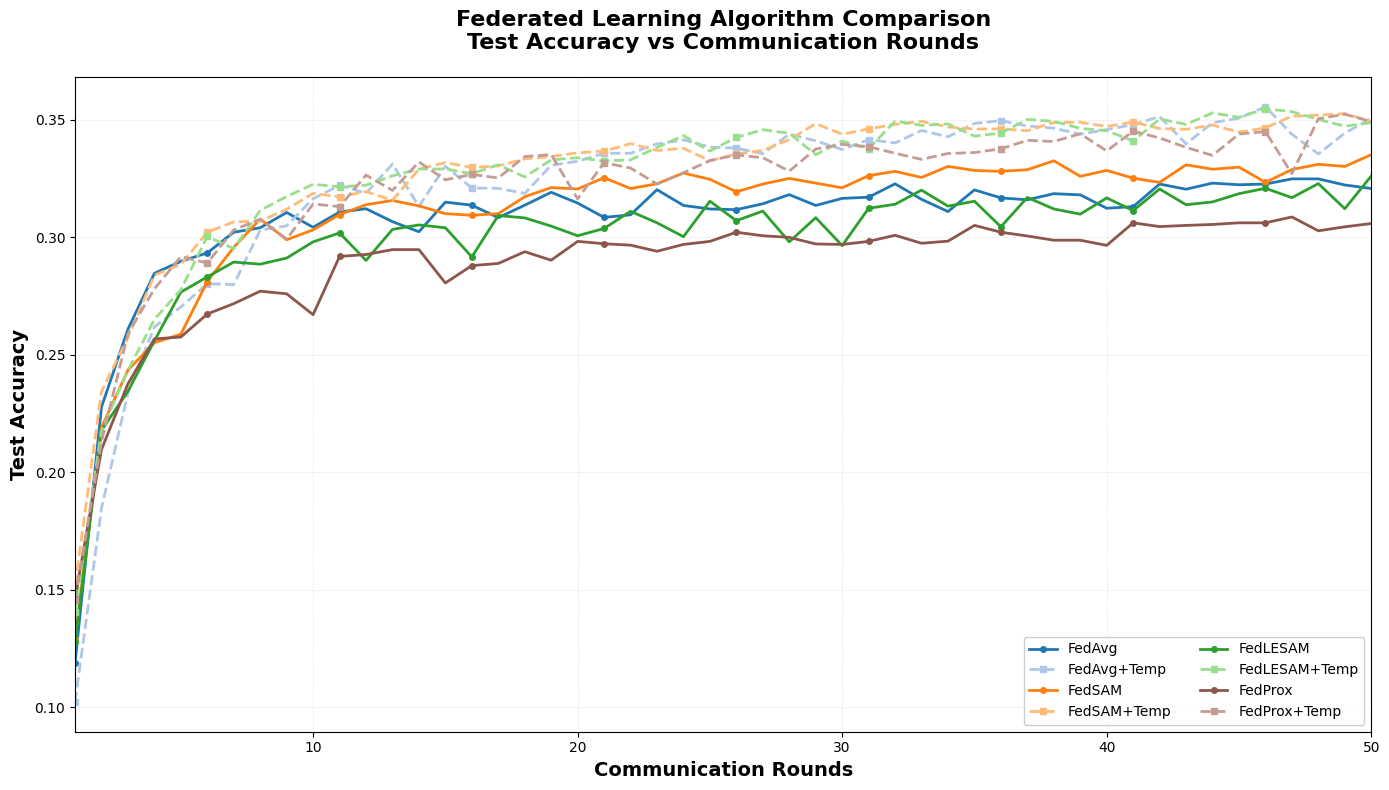


FINAL TEST ACCURACIES (Last Round)
FedAvg:          0.3207
FedAvg+Temp:     0.3505
FedSAM:          0.3351
FedSAM+Temp:     0.3492
FedLESAM:        0.3260
FedLESAM+Temp:   0.3487
FedProx:         0.3058
FedProx+Temp:    0.3492

🏆 BEST PERFORMING ALGORITHM: FedAvg+Temp with 0.3505 accuracy
################################################################################
RUNNING EXPERIMENTS WITH ALPHA:  0.5
################################################################################
Data partitioning complete.
Client 0 class dist: ['0:0.03', '1:0.01', '2:0.26', '3:0.23', '4:0.09', '5:0.00', '6:0.38', '7:0.00', '8:0.00', '9:0.00']
Client 1 class dist: ['0:0.05', '1:0.00', '2:0.23', '3:0.06', '4:0.02', '5:0.00', '6:0.00', '7:0.06', '8:0.18', '9:0.40']
Client 2 class dist: ['0:0.04', '1:0.02', '2:0.00', '3:0.20', '4:0.00', '5:0.70', '6:0.04', '7:0.00', '8:0.00', '9:0.00']
Client 3 class dist: ['0:0.40', '1:0.60', '2:0.00', '3:0.00', '4:0.00', '5:0.00', '6:0.00', '7:0.00', '8:0.00', '9:0

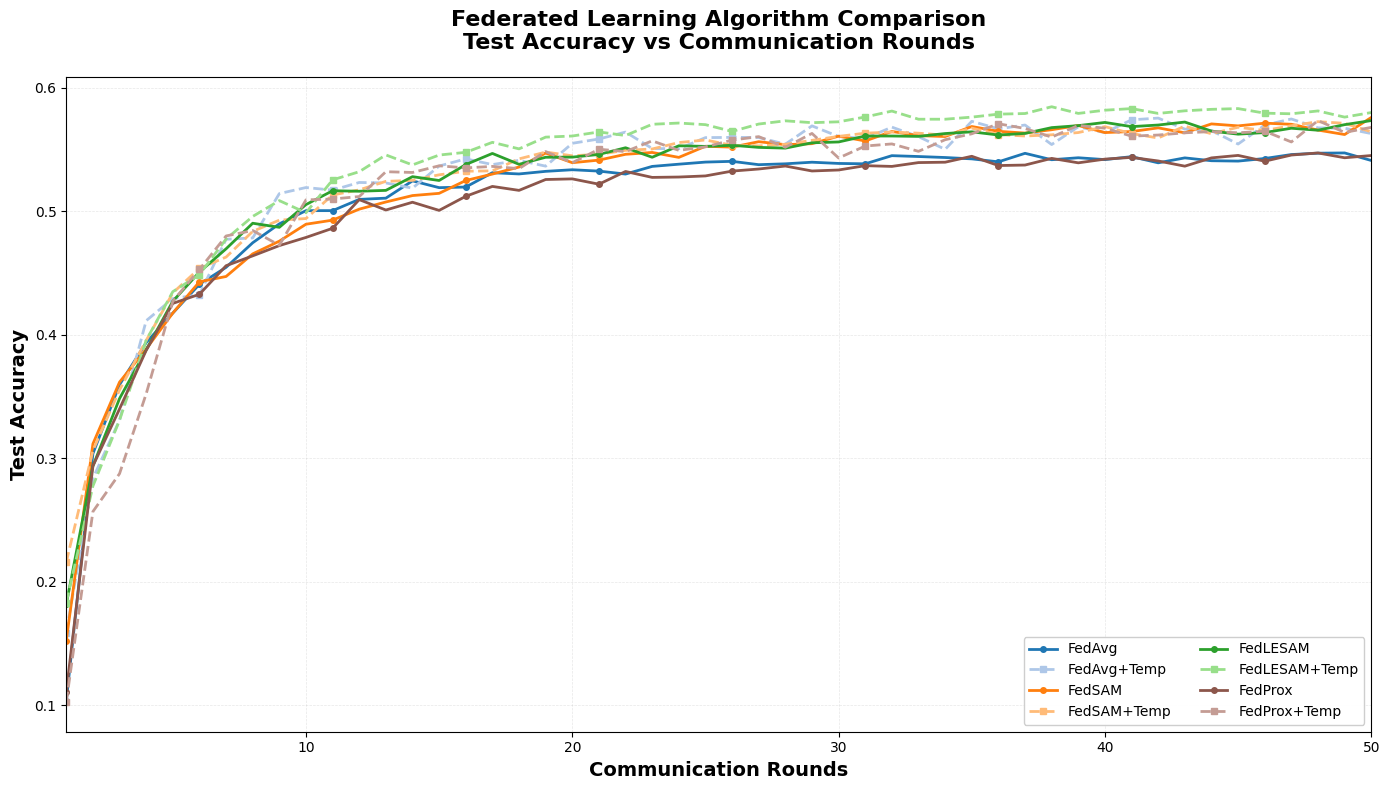


FINAL TEST ACCURACIES (Last Round)
FedAvg:          0.5410
FedAvg+Temp:     0.5628
FedSAM:          0.5758
FedSAM+Temp:     0.5642
FedLESAM:        0.5733
FedLESAM+Temp:   0.5798
FedProx:         0.5450
FedProx+Temp:    0.5678

🏆 BEST PERFORMING ALGORITHM: FedLESAM+Temp with 0.5798 accuracy
################################################################################
RUNNING EXPERIMENTS WITH ALPHA:  5
################################################################################
Data partitioning complete.
Client 0 class dist: ['0:0.02', '1:0.09', '2:0.09', '3:0.07', '4:0.13', '5:0.12', '6:0.07', '7:0.26', '8:0.01', '9:0.14']
Client 1 class dist: ['0:0.17', '1:0.06', '2:0.20', '3:0.09', '4:0.04', '5:0.08', '6:0.19', '7:0.06', '8:0.11', '9:0.00']
Client 2 class dist: ['0:0.03', '1:0.06', '2:0.13', '3:0.10', '4:0.11', '5:0.07', '6:0.14', '7:0.05', '8:0.13', '9:0.18']
Client 3 class dist: ['0:0.13', '1:0.08', '2:0.06', '3:0.11', '4:0.15', '5:0.04', '6:0.07', '7:0.05', '8:0.13', '9:0

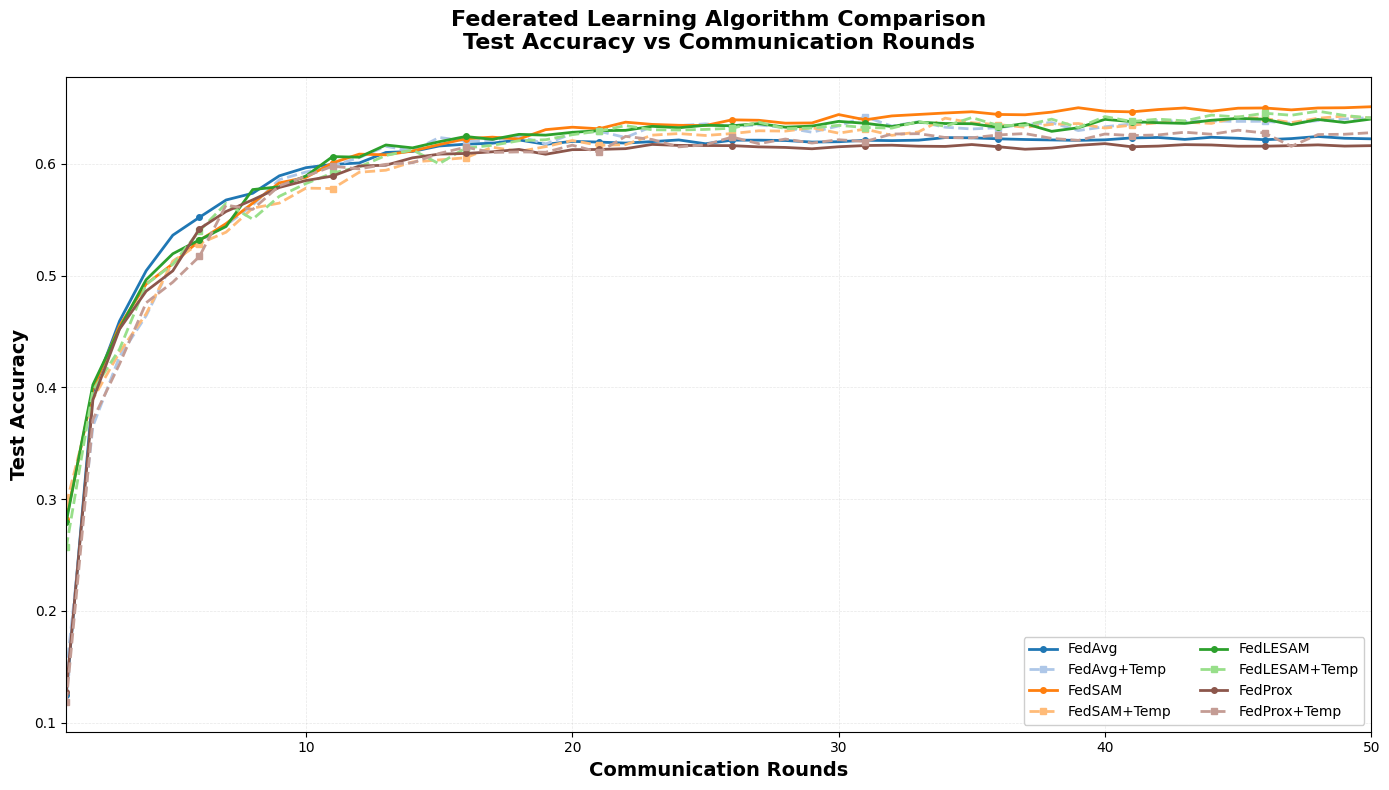


FINAL TEST ACCURACIES (Last Round)
FedAvg:          0.6223
FedAvg+Temp:     0.6414
FedSAM:          0.6510
FedSAM+Temp:     0.6408
FedLESAM:        0.6400
FedLESAM+Temp:   0.6409
FedProx:         0.6162
FedProx+Temp:    0.6278

🏆 BEST PERFORMING ALGORITHM: FedSAM with 0.6510 accuracy


In [9]:
for alph in [0.05, 0.5, 5]:
    print("#"*80)
    print("RUNNING EXPERIMENTS WITH ALPHA: ", alph)
    print("#"*80)
    
    train_loaders, val_loaders, test_loader, client_class_dist = load_and_partition_data(alpha=alph)

    print("\n[1/10] FedAvg...")
    test_accs_fedavg, model_fedavg = run_fedavg()
    
    print("\n[2/10] FedAvg+Temp...")
    test_accs_fedavg_temp, tau_fedavg_temp, model_fedavg_temp = run_fedavg_temp()
    
    print("\n[3/10] FedSAM...")
    test_accs_fedsam, model_fedsam = run_fedsam()
    
    print("\n[4/10] FedSAM+Temp...")
    test_accs_fedsam_temp, tau_fedsam_temp, model_fedsam_temp = run_fedsam_temp()
    
    print("\n[5/10] FedLESAM...")
    test_accs_fedlesam, model_fedlesam = run_fedlesam()
    
    print("\n[6/10] FedLESAM+Temp...")
    test_accs_fedlesam_temp, tau_fedlesam_temp, model_fedlesam_temp = run_fedlesam_temp()
    
    print("\n[11/10] FedProx...")
    test_accs_fedprox, model_fedprox = run_fedprox()
    
    print("\n[12/10] FedProx+Temp...")
    test_accs_fedprox_temp, tau_fedprox_temp, model_fedprox_temp = run_fedprox_temp()
    
    import matplotlib.pyplot as plt
    import numpy as np
    
    # ========================================
    # PLOTTING ALL ALGORITHMS
    # ========================================
    
    plt.figure(figsize=(14, 8))
    
    # Define colors and line styles for better distinction
    colors = {
        'FedAvg': '#1f77b4',
        'FedAvg+Temp': '#aec7e8',
        'FedSAM': '#ff7f0e',
        'FedSAM+Temp': '#ffbb78',
        'FedLESAM': '#2ca02c',
        'FedLESAM+Temp': '#98df8a',
        'FedSMOO': '#d62728',
        'FedSMOO+Temp': '#ff9896',
        'FedGMT': '#9467bd',
        'FedGMT+Temp': '#c5b0d5',
        'FedProx': '#8c564b',
        'FedProx+Temp': '#c49c94'
    }
    
    line_styles = {
        'FedAvg': '-',
        'FedAvg+Temp': '--',
        'FedSAM': '-',
        'FedSAM+Temp': '--',
        'FedLESAM': '-',
        'FedLESAM+Temp': '--',
        'FedSMOO': '-',
        'FedSMOO+Temp': '--',
        'FedGMT': '-',
        'FedGMT+Temp': '--',
        'FedProx': '-',
        'FedProx+Temp': '--'
    }
    
    # Communication rounds (x-axis)
    rounds = np.arange(1, len(test_accs_fedavg) + 1)
    
    # Plot all algorithms
    plt.plot(rounds, test_accs_fedavg, 
             color=colors['FedAvg'], linestyle=line_styles['FedAvg'], 
             linewidth=2, label='FedAvg', marker='o', markersize=4, markevery=5)
    
    plt.plot(rounds, test_accs_fedavg_temp, 
             color=colors['FedAvg+Temp'], linestyle=line_styles['FedAvg+Temp'], 
             linewidth=2, label='FedAvg+Temp', marker='s', markersize=4, markevery=5)
    
    plt.plot(rounds, test_accs_fedsam, 
             color=colors['FedSAM'], linestyle=line_styles['FedSAM'], 
             linewidth=2, label='FedSAM', marker='o', markersize=4, markevery=5)
    
    plt.plot(rounds, test_accs_fedsam_temp, 
             color=colors['FedSAM+Temp'], linestyle=line_styles['FedSAM+Temp'], 
             linewidth=2, label='FedSAM+Temp', marker='s', markersize=4, markevery=5)
    
    plt.plot(rounds, test_accs_fedlesam, 
             color=colors['FedLESAM'], linestyle=line_styles['FedLESAM'], 
             linewidth=2, label='FedLESAM', marker='o', markersize=4, markevery=5)
    
    plt.plot(rounds, test_accs_fedlesam_temp, 
             color=colors['FedLESAM+Temp'], linestyle=line_styles['FedLESAM+Temp'], 
             linewidth=2, label='FedLESAM+Temp', marker='s', markersize=4, markevery=5)
    
    # plt.plot(rounds, test_accs_fedsmoo, 
    #          color=colors['FedSMOO'], linestyle=line_styles['FedSMOO'], 
    #          linewidth=2, label='FedSMOO', marker='o', markersize=4, markevery=5)
    
    # plt.plot(rounds, test_accs_fedsmoo_temp, 
    #          color=colors['FedSMOO+Temp'], linestyle=line_styles['FedSMOO+Temp'], 
    #          linewidth=2, label='FedSMOO+Temp', marker='s', markersize=4, markevery=5)
    
    # plt.plot(rounds, test_accs_fedgmt, 
    #          color=colors['FedGMT'], linestyle=line_styles['FedGMT'], 
    #          linewidth=2, label='FedGMT', marker='o', markersize=4, markevery=5)
    
    # plt.plot(rounds, test_accs_fedgmt_temp, 
    #          color=colors['FedGMT+Temp'], linestyle=line_styles['FedGMT+Temp'], 
    #          linewidth=2, label='FedGMT+Temp', marker='s', markersize=4, markevery=5)
    
    plt.plot(rounds, test_accs_fedprox, 
             color=colors['FedProx'], linestyle=line_styles['FedProx'], 
             linewidth=2, label='FedProx', marker='o', markersize=4, markevery=5)
    
    plt.plot(rounds, test_accs_fedprox_temp, 
             color=colors['FedProx+Temp'], linestyle=line_styles['FedProx+Temp'], 
             linewidth=2, label='FedProx+Temp', marker='s', markersize=4, markevery=5)
    
    # Formatting
    plt.xlabel('Communication Rounds', fontsize=14, fontweight='bold')
    plt.ylabel('Test Accuracy', fontsize=14, fontweight='bold')
    plt.title('Federated Learning Algorithm Comparison\nTest Accuracy vs Communication Rounds', 
              fontsize=16, fontweight='bold', pad=20)
    plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    plt.legend(loc='lower right', fontsize=10, ncol=2, framealpha=0.95)
    
    # Set reasonable axis limits
    plt.xlim(1, len(test_accs_fedavg))
    
    plt.tight_layout()
    plt.show()
    
    # ========================================
    # PRINT FINAL ACCURACIES
    # ========================================
    
    print("\n" + "="*80)
    print("FINAL TEST ACCURACIES (Last Round)")
    print("="*80)
    print(f"FedAvg:          {test_accs_fedavg[-1]:.4f}")
    print(f"FedAvg+Temp:     {test_accs_fedavg_temp[-1]:.4f}")
    print(f"FedSAM:          {test_accs_fedsam[-1]:.4f}")
    print(f"FedSAM+Temp:     {test_accs_fedsam_temp[-1]:.4f}")
    print(f"FedLESAM:        {test_accs_fedlesam[-1]:.4f}")
    print(f"FedLESAM+Temp:   {test_accs_fedlesam_temp[-1]:.4f}")
    # print(f"FedSMOO:         {test_accs_fedsmoo[-1]:.4f}")
    # print(f"FedSMOO+Temp:    {test_accs_fedsmoo_temp[-1]:.4f}")
    # print(f"FedGMT:          {test_accs_fedgmt[-1]:.4f}")
    # print(f"FedGMT+Temp:     {test_accs_fedgmt_temp[-1]:.4f}")
    print(f"FedProx:         {test_accs_fedprox[-1]:.4f}")
    print(f"FedProx+Temp:    {test_accs_fedprox_temp[-1]:.4f}")
    print("="*80)
    
    # Find best performing algorithm
    all_results = {
        'FedAvg': test_accs_fedavg[-1],
        'FedAvg+Temp': test_accs_fedavg_temp[-1],
        'FedSAM': test_accs_fedsam[-1],
        'FedSAM+Temp': test_accs_fedsam_temp[-1],
        'FedLESAM': test_accs_fedlesam[-1],
        'FedLESAM+Temp': test_accs_fedlesam_temp[-1],
        # 'FedSMOO': test_accs_fedsmoo[-1],
        # 'FedSMOO+Temp': test_accs_fedsmoo_temp[-1],
        # 'FedGMT': test_accs_fedgmt[-1],
        # 'FedGMT+Temp': test_accs_fedgmt_temp[-1],
        'FedProx': test_accs_fedprox[-1],
        'FedProx+Temp': test_accs_fedprox_temp[-1]
    }
    
    best_algo = max(all_results, key=all_results.get)
    print(f"\n🏆 BEST PERFORMING ALGORITHM: {best_algo} with {all_results[best_algo]:.4f} accuracy")
    print("="*80)
    